In [1]:
'''
2022.3.9
术后预后模型：
    生存时间模型
    风险评分模型
'''

'\n2022.3.9\n术后预后模型：\n    生存时间模型\n    风险评分模型\n'

In [2]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [3]:
df_model =pd.read_excel(project_path +'/data/result/feature_engineering/df_4.5_model_data_forward-术后.xlsx',index_col=0)

In [4]:
df_model.columns

Index(['label', 'jaundice', 'N', 'M', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T',
       'Bismuth_C', 'cardio_disease', 'nbdd', 'HCVAb', 'DB', 'ALT',
       'biliary_disease', 'HBsAg', 'T', 'surgery_result', 'emaciation',
       'tumor_CEA', 'tumor_CA19-9', 'tumor_CA125', 'tumor_size', 'tumor_AFP'],
      dtype='object')

In [5]:
df_model.shape

(417, 23)

In [6]:
df_model['label'].value_counts()

2    129
1    111
0    100
3     77
Name: label, dtype: int64

In [7]:
discrete_col=['jaundice', 'N', 'M', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T','Bismuth_C', 'cardio_disease', 
              'nbdd', 'HCVAb','biliary_disease', 'HBsAg', 'T', 'surgery_result', 'emaciation']

continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('label')

## 数据归一化

In [8]:
# 防止不同维特征数据差距过大，影响建模效果
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# df_model[continuous_col]=ss.fit_transform(df_model[continuous_col])
for i in continuous_col:
    df_model[[i]] = ss.fit_transform(df_model[[i]])

In [9]:
df_model.columns

Index(['label', 'jaundice', 'N', 'M', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T',
       'Bismuth_C', 'cardio_disease', 'nbdd', 'HCVAb', 'DB', 'ALT',
       'biliary_disease', 'HBsAg', 'T', 'surgery_result', 'emaciation',
       'tumor_CEA', 'tumor_CA19-9', 'tumor_CA125', 'tumor_size', 'tumor_AFP'],
      dtype='object')

In [10]:
df_model.to_excel(project_path+'/data/result/modeling/df_1.2_数据归一化.xlsx')

## 插补数据

In [11]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum()>0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)

        rfr = RandomForestRegressor(n_estimators=300,
                                    random_state=3)
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [12]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)
# df_model_cb=df_model

In [13]:
df_model_cb.shape

(417, 23)

In [14]:
# 保存插补数据
df_model_cb.to_excel(project_path + '/data/result/modeling/df_1.3_model_data_插补.xlsx')

## 划分数据集

### 计算随机数种子

In [15]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['label'],axis=1)
y = df_model_cb['label']

seeds_list=[]
cat_f1_list=[]
for i in range(101):
    
    tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=i)
    
    # 分类数据过采样
    from imblearn.over_sampling import SMOTE,ADASYN 
    sm = SMOTE(random_state=0)
    tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)
#     tran_x_sm,tran_y_sm=tran_x,tran_y
    
    import xgboost
    cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
    # 分类模型
    cat_model.fit(tran_x_sm,tran_y_sm)
    cat_predictions=cat_model.predict(test_x)
    cat_f1=f1_score(test_y,cat_predictions,average='macro')
    # 防止分类数据的测试集划分不平衡
    if not (2 >=(test_y.value_counts().values[0])/(test_y.value_counts().values[-1]) >=1):
        continue

#     import catboost
#     # CatBoost模型
#     cat_model=catboost.CatBoostRegressor(iterations=300, 
#                                           learning_rate=0.2, 
#                                           depth=6,
#                                           l2_leaf_reg=2,
#                                           subsample=1,
#                                           loss_function='RMSE', # 'CrossEntropy',
#                                           random_state=3)
#     # 回归模型
#     cat_model.fit(tran_x,tran_y)
#     cat_predictions=cat_model.predict(test_x)
#     cat_f1=r2_score(test_y,cat_predictions)
    
    seeds_list.append(i)
    cat_f1_list.append(cat_f1)

[22:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[22:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[22:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[22:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:02:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[22:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

[22:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [16]:
test_y.value_counts()

1    27
2    20
0    20
3    17
Name: label, dtype: int64

In [17]:
df_seeds=pd.DataFrame(data={'seed':seeds_list,
                           'cat_f1':cat_f1_list})
df_seeds=df_seeds.sort_values(['cat_f1'], ascending=0).reset_index(drop=True)
df_seeds.to_excel(project_path+'/data/df_seeds.xlsx')

In [19]:
seed_index=df_seeds.loc[0,'seed']

In [20]:
seed_index

17

### 划分数据集

In [317]:
# 分类随机数种子
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['label'],axis=1)
y = df_model_cb['label']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=seed_index)

In [318]:
seed_index

17

In [319]:
df_model.shape

(417, 23)

In [320]:
print(tran_x.shape)
print(test_x.shape)

(333, 22)
(84, 22)


In [321]:
df_model.label.value_counts()

2    129
1    111
0    100
3     77
Name: label, dtype: int64

In [322]:
tran_y.value_counts()

2    108
1     86
0     80
3     59
Name: label, dtype: int64

In [323]:
test_y.value_counts()

1    25
2    21
0    20
3    18
Name: label, dtype: int64

In [324]:
tran_x.head()

,jaundice,N,M,Gazzaniga_T,MSKCC,Blumgart_T,Bismuth_C,cardio_disease,nbdd,HCVAb,...,biliary_disease,HBsAg,T,surgery_result,emaciation,tumor_CEA,tumor_CA19-9,tumor_CA125,tumor_size,tumor_AFP
302,1,0.0,0.0,1.0,1.0,1.0,3.0,0,0,0.0,...,0.0,0.000000,2.0,0.0,0.000000,-0.214341,-0.916045,-0.205619,0.106830,-0.112759
375,1,0.0,0.0,1.0,1.0,1.0,2.0,0,0,0.0,...,0.0,0.053333,2.0,0.0,0.226667,-0.260471,1.666576,-0.134375,-0.753887,-0.097976
214,1,0.0,0.0,1.0,1.0,1.0,3.0,0,1,0.0,...,0.0,0.000000,2.0,0.0,0.000000,0.120107,-0.601906,-0.137012,-1.614604,-0.093049
255,1,0.0,0.0,1.0,1.0,1.0,3.0,0,0,0.0,...,0.0,0.000000,2.0,0.0,0.226667,-0.179743,0.350135,-0.121279,-0.753887,-0.009282
235,1,1.0,0.0,1.0,1.0,1.0,2.0,0,1,0.0,...,0.0,0.000000,4.0,1.0,0.000000,-0.164143,-0.820867,-0.184461,0.106830,-0.087308


In [325]:
test_x.head()

,jaundice,N,M,Gazzaniga_T,MSKCC,Blumgart_T,Bismuth_C,cardio_disease,nbdd,HCVAb,...,biliary_disease,HBsAg,T,surgery_result,emaciation,tumor_CEA,tumor_CA19-9,tumor_CA125,tumor_size,tumor_AFP
379,1,0.0,0.0,3.0,3.0,4.0,3.0,0,0,0.0,...,0.0,0.0,4.0,0.0,0.0,-0.231640,-1.005340,-0.185416,0.106830,-0.117686
42,0,0.0,0.0,1.0,1.0,1.0,3.0,0,0,0.0,...,0.0,0.0,2.0,0.0,0.0,-0.168210,-0.903479,-0.224759,-1.528532,0.049847
250,1,0.0,0.0,1.0,1.0,1.0,1.0,0,0,0.0,...,0.0,0.0,2.0,0.0,2.0,-0.012519,-0.267716,-0.092006,0.106830,0.059702
320,1,0.0,0.0,1.0,1.0,1.0,2.0,0,0,0.0,...,0.0,0.0,2.0,0.0,0.0,-0.179743,-0.468230,0.112319,-0.323528,-0.043774
221,1,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0.0,...,0.0,0.0,2.0,0.0,0.0,-0.248939,-0.918985,-0.206682,-0.227128,0.025210


In [326]:
test_y

379    0
42     0
250    3
320    1
221    3
      ..
3      1
189    2
13     1
301    1
293    3
Name: label, Length: 84, dtype: int64

In [327]:
type(test_y)

pandas.core.series.Series

## 训练集过采样

In [328]:
# 进行过采样
from imblearn.over_sampling import SMOTE,ADASYN 
from imblearn.combine import SMOTETomek
sm = SMOTE(random_state=0)
# sm=ADASYN(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [329]:
tran_x_sm.shape

(432, 22)

In [330]:
tran_y_sm.value_counts()

3    108
2    108
1    108
0    108
Name: label, dtype: int64

In [331]:
tran_x_sm.head()

,jaundice,N,M,Gazzaniga_T,MSKCC,Blumgart_T,Bismuth_C,cardio_disease,nbdd,HCVAb,...,biliary_disease,HBsAg,T,surgery_result,emaciation,tumor_CEA,tumor_CA19-9,tumor_CA125,tumor_size,tumor_AFP
0,1,0.0,0.0,1.0,1.0,1.0,3.0,0,0,0.0,...,0.0,0.000000,2.0,0.0,0.000000,-0.214341,-0.916045,-0.205619,0.106830,-0.112759
1,1,0.0,0.0,1.0,1.0,1.0,2.0,0,0,0.0,...,0.0,0.053333,2.0,0.0,0.226667,-0.260471,1.666576,-0.134375,-0.753887,-0.097976
2,1,0.0,0.0,1.0,1.0,1.0,3.0,0,1,0.0,...,0.0,0.000000,2.0,0.0,0.000000,0.120107,-0.601906,-0.137012,-1.614604,-0.093049
3,1,0.0,0.0,1.0,1.0,1.0,3.0,0,0,0.0,...,0.0,0.000000,2.0,0.0,0.226667,-0.179743,0.350135,-0.121279,-0.753887,-0.009282
4,1,1.0,0.0,1.0,1.0,1.0,2.0,0,1,0.0,...,0.0,0.000000,4.0,1.0,0.000000,-0.164143,-0.820867,-0.184461,0.106830,-0.087308


In [332]:
tran_x_sm.to_excel(project_path+'/data/tran_x_sm.xlsx')
tran_y_sm.to_excel(project_path+'/data/tran_y_sm.xlsx')

## 多分类模型：5-fold on training dataset

### training dataset:5-fold

In [333]:
seed_index

17

In [337]:
from sklearn.model_selection import KFold

# 划分训练集和测试集，比例为8:2
x = tran_x_sm.copy()
y = tran_y_sm.copy()
# 五折交叉验证
kf = KFold(n_splits=5,random_state=seed_index,shuffle=True)

df_temp_result=pd.DataFrame()
temp_importance_list=[]
for train_index, test_index in kf.split(x):
    tran_x_kf,test_x_kf,tran_y_kf,test_y_kf=x.values[train_index],x.values[test_index],y.values[train_index],y.values[test_index]
    from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
    import xgboost
    # XGBoost模型
    xgb_model=xgboost.XGBClassifier(max_depth=8,
                            learning_rate=0.03,
                            n_estimators=500,
                            min_child_weight=0.5,
                            eta=0.1,
                            gamma=0.5,
                            reg_lambda=5,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            nthread=4,
                            scale_pos_weight=1,
                            random_state=3)
    xgb_model.fit(tran_x_kf,tran_y_kf)

    import lightgbm
    # LightGBM模型
    lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                      max_depth=5,
                                      min_child_weight=0.5,
                                      gamma=0.5,
                                       reg_lambda=5,
                                      subsample=0.8,
                                      learning_rate=0.01, 
                                      loss_function='CrossEntropy',
                                      random_state=3)
    lgbm_model.fit(tran_x_kf,tran_y_kf)

    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=400, 
                                          learning_rate=0.1,
                                          depth=6,
                                          l2_leaf_reg=2,
                                          loss_function='MultiClass',
                                          random_state=3)
    cat_model.fit(tran_x_kf,tran_y_kf)
    
    # 随机森林
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
    # 根据已有数据去拟合随机森林模型
    grid.fit(tran_x_sm, tran_y_sm)
    rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                max_depth=8,
                                random_state=3)
    rf_model.fit(tran_x_kf, tran_y_kf)
    # 预测缺失值

    # GBDT
    # 列出参数列表
    gbdt_model = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=8,
                                subsample=0.4,
                                random_state=3)
    gbdt_model.fit(tran_x_kf,tran_y_kf)
    # 预测缺失值

    # SVR
    from sklearn.svm import SVR,SVC
    # 回归模型
    # svr = SVR(kernel='linear', C=1.25)
    # 分类模型
    svr_model = SVC(kernel='rbf',
              C=50,
              cache_size=200,
                probability=True,
              random_state=3)
    svr_model.fit(tran_x_kf,tran_y_kf)

    # Linear回归，Lasso回归，领回归，logistic回归
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
    lcv_model = LogisticRegression(penalty='l2',
                             C=5,
                            solver='lbfgs',
                             max_iter=100,
                            random_state=3)
    # lcv = Lasso()
    # lcv = Ridge()
    lcv_model.fit(tran_x_kf, tran_y_kf)

    # ANN
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report,confusion_matrix

    ANN_model = MLPClassifier(alpha=0.1, 
                        hidden_layer_sizes=[100,], 
                        solver='adam', 
                        activation='relu', 
                        random_state=3)
    ANN_model.fit(tran_x_kf, tran_y_kf)

    # TabNet
    from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
    from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
    import torch
    TabNet_model = TabNetMultiTaskClassifier(
                           cat_emb_dim=1,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":50, # how to use learning rate scheduler
                                             "gamma":0.9},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='entmax') # "sparsemax"
    tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_kf, tran_y_kf, test_size=0.125, random_state=3)

    TabNet_model.fit(X_train=tran_x_kf, 
            y_train=tran_y_kf.reshape(-1,1),
            max_epochs=200, 
            patience=20,
            batch_size=128, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False,
            loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

    # 计算评价指标compute evaluation metrics
    from sklearn.metrics import classification_report,confusion_matrix
    # 统一模型输出结果
    df_model_result=pd.DataFrame(
        columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

    model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
    model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
#     model_list=[cat_model]
#     model_name_list=['CatBoost']
    
    temp_auc=pd.DataFrame(columns=['model','precision','recall','f1','accuracy','AUC'])    
    for model,name in zip(model_list,model_name_list):
        print(name)
        # 计算accuracy和AUC
        # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
        test_y_score=np.reshape(model.predict_proba(test_x_kf),(-1,4))
        auc=roc_auc_score(test_y_kf,test_y_score,multi_class='ovr')
        auc=round(auc,2)
        # tabnet predict结果是三维数组，无法计算auc，需要reshape
        predictions=np.reshape(model.predict(test_x_kf),(-1,1)).astype(str)
        accuracy=accuracy_score(test_y_kf.astype(str),predictions)
        accuracy=round(accuracy,2)
        # 计算precision、recall、F1
        precision=precision_score(test_y_kf.astype(str),predictions,average='macro')
        precision=round(precision,2)
        recall=recall_score(test_y_kf.astype(str),predictions,average='macro')
        recall=round(recall,2)
        f1=f1_score(test_y_kf.astype(str),predictions,average='macro')
        f1=round(f1,2)
        temp_auc.loc[temp_auc.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                    [name,precision,recall,f1,accuracy,auc]
    df_temp_result=pd.concat([df_temp_result,temp_auc],axis=0)
                                       
    # 变量重要性评分
    importance = cat_model.feature_importances_
    df_importance_temp=pd.DataFrame(data={'特征':x.columns,'重要性评分':importance})
    temp_importance_list.append(df_importance_temp)
    

[12:05:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0:	learn: 1.3585635	total: 4.25ms	remaining: 1.7s
1:	learn: 1.3222115	total: 8.63ms	remaining: 1.72s
2:	learn: 1.2946708	total: 13.4ms	remaining: 1.78s
3:	learn: 1.2637432	total: 18.6ms	remaining: 1.84s
4:	learn: 1.2377976	total: 22ms	remaining: 1.74s
5:	learn: 1.2125150	total: 25.8ms	remaining: 1.7s
6:	learn: 1.1916469	total: 29.6ms	remaining: 1.66s
7:	learn: 1.1685586	total: 33.1ms	remaining: 1.62s
8:	learn: 1.1440411	total: 36.5ms	remaining: 1.59s
9:	learn: 1.1253075	total: 40.1ms	remaining: 1.56s
10:	learn: 1.1102433	total: 44.2ms	remaining: 1.56s
11:	learn: 1.0903

198:	learn: 0.1925331	total: 713ms	remaining: 720ms
199:	learn: 0.1916148	total: 717ms	remaining: 717ms
200:	learn: 0.1902551	total: 721ms	remaining: 714ms
201:	learn: 0.1887869	total: 725ms	remaining: 710ms
202:	learn: 0.1880565	total: 728ms	remaining: 706ms
203:	learn: 0.1868042	total: 731ms	remaining: 702ms
204:	learn: 0.1858565	total: 734ms	remaining: 698ms
205:	learn: 0.1843918	total: 738ms	remaining: 695ms
206:	learn: 0.1834683	total: 741ms	remaining: 691ms
207:	learn: 0.1824834	total: 744ms	remaining: 687ms
208:	learn: 0.1814836	total: 748ms	remaining: 683ms
209:	learn: 0.1802268	total: 752ms	remaining: 680ms
210:	learn: 0.1793747	total: 756ms	remaining: 677ms
211:	learn: 0.1784312	total: 759ms	remaining: 673ms
212:	learn: 0.1775948	total: 762ms	remaining: 669ms
213:	learn: 0.1765903	total: 765ms	remaining: 665ms
214:	learn: 0.1752404	total: 768ms	remaining: 661ms
215:	learn: 0.1739858	total: 772ms	remaining: 657ms
216:	learn: 0.1729467	total: 775ms	remaining: 654ms
217:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.96432 |  0:00:00s
epoch 1  | loss: 1.63505 |  0:00:00s
epoch 2  | loss: 1.52703 |  0:00:00s
epoch 3  | loss: 1.44452 |  0:00:00s
epoch 4  | loss: 1.43137 |  0:00:00s
epoch 5  | loss: 1.36454 |  0:00:00s
epoch 6  | loss: 1.35845 |  0:00:00s
epoch 7  | loss: 1.3507  |  0:00:00s
epoch 8  | loss: 1.33069 |  0:00:00s
epoch 9  | loss: 1.3209  |  0:00:00s
epoch 10 | loss: 1.29466 |  0:00:00s
epoch 11 | loss: 1.30288 |  0:00:00s
epoch 12 | loss: 1.29966 |  0:00:01s
epoch 13 | loss: 1.29823 |  0:00:01s
epoch 14 | loss: 1.2539  |  0:00:01s
epoch 15 | loss: 1.26351 |  0:00:01s
epoch 16 | loss: 1.24045 |  0:00:01s
epoch 17 | loss: 1.20963 |  0:00:01s
epoch 18 | loss: 1.20077 |  0:00:01s
epoch 19 | loss: 1.22846 |  0:00:01s
epoch 20 | loss: 1.22331 |  0:00:01s
epoch 21 | loss: 1.18842 |  0:00:01s
epoch 22 | loss: 1.16835 |  0:00:01s
epoch 23 | loss: 1.16372 |  0:00:01s
epoch 24 | loss: 1.17

9:	learn: 1.1606698	total: 44.5ms	remaining: 1.74s
10:	learn: 1.1435711	total: 48.2ms	remaining: 1.7s
11:	learn: 1.1298960	total: 52ms	remaining: 1.68s
12:	learn: 1.1129454	total: 56.3ms	remaining: 1.68s
13:	learn: 1.0940416	total: 60.1ms	remaining: 1.66s
14:	learn: 1.0798032	total: 64.2ms	remaining: 1.65s
15:	learn: 1.0678150	total: 68.1ms	remaining: 1.63s
16:	learn: 1.0451090	total: 71.8ms	remaining: 1.62s
17:	learn: 1.0308581	total: 75.4ms	remaining: 1.6s
18:	learn: 1.0155439	total: 80ms	remaining: 1.6s
19:	learn: 1.0028890	total: 86.6ms	remaining: 1.65s
20:	learn: 0.9864381	total: 90.1ms	remaining: 1.63s
21:	learn: 0.9773057	total: 93.1ms	remaining: 1.6s
22:	learn: 0.9649354	total: 96.1ms	remaining: 1.57s
23:	learn: 0.9506875	total: 99.1ms	remaining: 1.55s
24:	learn: 0.9404474	total: 103ms	remaining: 1.54s
25:	learn: 0.9258776	total: 106ms	remaining: 1.52s
26:	learn: 0.9139234	total: 109ms	remaining: 1.5s
27:	learn: 0.9029393	total: 112ms	remaining: 1.48s
28:	learn: 0.8899547	total

208:	learn: 0.1865271	total: 753ms	remaining: 688ms
209:	learn: 0.1855174	total: 756ms	remaining: 684ms
210:	learn: 0.1839730	total: 759ms	remaining: 680ms
211:	learn: 0.1831569	total: 762ms	remaining: 676ms
212:	learn: 0.1824332	total: 765ms	remaining: 672ms
213:	learn: 0.1807288	total: 769ms	remaining: 668ms
214:	learn: 0.1801852	total: 772ms	remaining: 665ms
215:	learn: 0.1787035	total: 777ms	remaining: 662ms
216:	learn: 0.1784266	total: 780ms	remaining: 658ms
217:	learn: 0.1773163	total: 785ms	remaining: 655ms
218:	learn: 0.1763363	total: 791ms	remaining: 654ms
219:	learn: 0.1753235	total: 794ms	remaining: 650ms
220:	learn: 0.1744773	total: 797ms	remaining: 646ms
221:	learn: 0.1734833	total: 801ms	remaining: 642ms
222:	learn: 0.1728095	total: 804ms	remaining: 638ms
223:	learn: 0.1718165	total: 807ms	remaining: 634ms
224:	learn: 0.1706480	total: 810ms	remaining: 630ms
225:	learn: 0.1694550	total: 812ms	remaining: 626ms
226:	learn: 0.1687213	total: 816ms	remaining: 622ms
227:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.94829 |  0:00:00s
epoch 1  | loss: 1.62086 |  0:00:00s
epoch 2  | loss: 1.42165 |  0:00:00s
epoch 3  | loss: 1.44398 |  0:00:00s
epoch 4  | loss: 1.3589  |  0:00:00s
epoch 5  | loss: 1.36435 |  0:00:00s
epoch 6  | loss: 1.33562 |  0:00:00s
epoch 7  | loss: 1.30616 |  0:00:00s
epoch 8  | loss: 1.3063  |  0:00:00s
epoch 9  | loss: 1.28525 |  0:00:00s
epoch 10 | loss: 1.2777  |  0:00:00s
epoch 11 | loss: 1.26247 |  0:00:00s
epoch 12 | loss: 1.23666 |  0:00:01s
epoch 13 | loss: 1.2198  |  0:00:01s
epoch 14 | loss: 1.22621 |  0:00:01s
epoch 15 | loss: 1.21    |  0:00:01s
epoch 16 | loss: 1.21861 |  0:00:01s
epoch 17 | loss: 1.19868 |  0:00:01s
epoch 18 | loss: 1.1601  |  0:00:01s
epoch 19 | loss: 1.21235 |  0:00:01s
epoch 20 | loss: 1.18655 |  0:00:01s
epoch 21 | loss: 1.16781 |  0:00:01s
epoch 22 | loss: 1.21008 |  0:00:01s
epoch 23 | loss: 1.14811 |  0:00:02s
epoch 24 | loss: 1.17

12:	learn: 1.0996084	total: 52ms	remaining: 1.55s
13:	learn: 1.0828364	total: 58.6ms	remaining: 1.61s
14:	learn: 1.0636048	total: 62.4ms	remaining: 1.6s
15:	learn: 1.0552024	total: 66.2ms	remaining: 1.59s
16:	learn: 1.0426886	total: 70.7ms	remaining: 1.59s
17:	learn: 1.0265720	total: 74.6ms	remaining: 1.58s
18:	learn: 1.0088848	total: 78ms	remaining: 1.56s
19:	learn: 0.9972982	total: 81.4ms	remaining: 1.55s
20:	learn: 0.9823573	total: 85.1ms	remaining: 1.53s
21:	learn: 0.9721839	total: 88.5ms	remaining: 1.52s
22:	learn: 0.9628680	total: 91.5ms	remaining: 1.5s
23:	learn: 0.9493107	total: 94.5ms	remaining: 1.48s
24:	learn: 0.9408032	total: 97.7ms	remaining: 1.47s
25:	learn: 0.9265171	total: 102ms	remaining: 1.47s
26:	learn: 0.9129324	total: 106ms	remaining: 1.47s
27:	learn: 0.8997750	total: 111ms	remaining: 1.47s
28:	learn: 0.8883787	total: 114ms	remaining: 1.46s
29:	learn: 0.8776972	total: 119ms	remaining: 1.47s
30:	learn: 0.8665832	total: 124ms	remaining: 1.47s
31:	learn: 0.8582999	tot

216:	learn: 0.1828513	total: 766ms	remaining: 646ms
217:	learn: 0.1820479	total: 772ms	remaining: 645ms
218:	learn: 0.1812458	total: 777ms	remaining: 642ms
219:	learn: 0.1799328	total: 781ms	remaining: 639ms
220:	learn: 0.1784443	total: 785ms	remaining: 636ms
221:	learn: 0.1772004	total: 790ms	remaining: 633ms
222:	learn: 0.1765832	total: 794ms	remaining: 630ms
223:	learn: 0.1754951	total: 798ms	remaining: 627ms
224:	learn: 0.1748475	total: 802ms	remaining: 623ms
225:	learn: 0.1733088	total: 805ms	remaining: 620ms
226:	learn: 0.1721699	total: 808ms	remaining: 616ms
227:	learn: 0.1709400	total: 811ms	remaining: 612ms
228:	learn: 0.1696957	total: 817ms	remaining: 610ms
229:	learn: 0.1692801	total: 820ms	remaining: 606ms
230:	learn: 0.1685346	total: 825ms	remaining: 604ms
231:	learn: 0.1677856	total: 829ms	remaining: 600ms
232:	learn: 0.1669205	total: 833ms	remaining: 597ms
233:	learn: 0.1659617	total: 837ms	remaining: 594ms
234:	learn: 0.1652714	total: 841ms	remaining: 591ms
235:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.88479 |  0:00:00s
epoch 1  | loss: 1.56658 |  0:00:00s
epoch 2  | loss: 1.45543 |  0:00:00s
epoch 3  | loss: 1.42973 |  0:00:00s
epoch 4  | loss: 1.39428 |  0:00:00s
epoch 5  | loss: 1.37443 |  0:00:00s
epoch 6  | loss: 1.31041 |  0:00:00s
epoch 7  | loss: 1.34905 |  0:00:00s
epoch 8  | loss: 1.35275 |  0:00:00s
epoch 9  | loss: 1.34232 |  0:00:00s
epoch 10 | loss: 1.33529 |  0:00:00s
epoch 11 | loss: 1.32465 |  0:00:00s
epoch 12 | loss: 1.31009 |  0:00:01s
epoch 13 | loss: 1.2733  |  0:00:01s
epoch 14 | loss: 1.25294 |  0:00:01s
epoch 15 | loss: 1.25745 |  0:00:01s
epoch 16 | loss: 1.23611 |  0:00:01s
epoch 17 | loss: 1.20471 |  0:00:01s
epoch 18 | loss: 1.19946 |  0:00:01s
epoch 19 | loss: 1.23177 |  0:00:01s
epoch 20 | loss: 1.19483 |  0:00:01s
epoch 21 | loss: 1.20145 |  0:00:01s
epoch 22 | loss: 1.1796  |  0:00:01s
epoch 23 | loss: 1.21884 |  0:00:01s
epoch 24 | loss: 1.17

12:	learn: 1.0900870	total: 58.9ms	remaining: 1.75s
13:	learn: 1.0710292	total: 62.5ms	remaining: 1.72s
14:	learn: 1.0559259	total: 66.2ms	remaining: 1.7s
15:	learn: 1.0462930	total: 69.9ms	remaining: 1.68s
16:	learn: 1.0337405	total: 73.6ms	remaining: 1.66s
17:	learn: 1.0180668	total: 76.9ms	remaining: 1.63s
18:	learn: 1.0011471	total: 80.4ms	remaining: 1.61s
19:	learn: 0.9879225	total: 83.9ms	remaining: 1.59s
20:	learn: 0.9756952	total: 88.1ms	remaining: 1.59s
21:	learn: 0.9650530	total: 91.5ms	remaining: 1.57s
22:	learn: 0.9538666	total: 94.8ms	remaining: 1.55s
23:	learn: 0.9415274	total: 99.1ms	remaining: 1.55s
24:	learn: 0.9316383	total: 104ms	remaining: 1.56s
25:	learn: 0.9194394	total: 107ms	remaining: 1.54s
26:	learn: 0.9081129	total: 110ms	remaining: 1.52s
27:	learn: 0.8974975	total: 115ms	remaining: 1.53s
28:	learn: 0.8859822	total: 119ms	remaining: 1.53s
29:	learn: 0.8760175	total: 123ms	remaining: 1.51s
30:	learn: 0.8660445	total: 126ms	remaining: 1.5s
31:	learn: 0.8575177	

217:	learn: 0.1781326	total: 771ms	remaining: 643ms
218:	learn: 0.1767134	total: 774ms	remaining: 640ms
219:	learn: 0.1761126	total: 778ms	remaining: 637ms
220:	learn: 0.1752487	total: 781ms	remaining: 633ms
221:	learn: 0.1737166	total: 788ms	remaining: 632ms
222:	learn: 0.1723050	total: 793ms	remaining: 629ms
223:	learn: 0.1712601	total: 798ms	remaining: 627ms
224:	learn: 0.1701711	total: 802ms	remaining: 624ms
225:	learn: 0.1691053	total: 806ms	remaining: 621ms
226:	learn: 0.1681884	total: 810ms	remaining: 617ms
227:	learn: 0.1668497	total: 814ms	remaining: 614ms
228:	learn: 0.1657091	total: 818ms	remaining: 611ms
229:	learn: 0.1645085	total: 821ms	remaining: 607ms
230:	learn: 0.1635774	total: 825ms	remaining: 603ms
231:	learn: 0.1625293	total: 828ms	remaining: 600ms
232:	learn: 0.1612512	total: 833ms	remaining: 597ms
233:	learn: 0.1604957	total: 836ms	remaining: 593ms
234:	learn: 0.1597991	total: 840ms	remaining: 590ms
235:	learn: 0.1590943	total: 845ms	remaining: 587ms
236:	learn: 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.92762 |  0:00:00s
epoch 1  | loss: 1.61629 |  0:00:00s
epoch 2  | loss: 1.44294 |  0:00:00s
epoch 3  | loss: 1.49889 |  0:00:00s
epoch 4  | loss: 1.39614 |  0:00:00s
epoch 5  | loss: 1.3572  |  0:00:00s
epoch 6  | loss: 1.3052  |  0:00:00s
epoch 7  | loss: 1.30067 |  0:00:00s
epoch 8  | loss: 1.28736 |  0:00:00s
epoch 9  | loss: 1.27142 |  0:00:00s
epoch 10 | loss: 1.27026 |  0:00:00s
epoch 11 | loss: 1.25585 |  0:00:01s
epoch 12 | loss: 1.28808 |  0:00:01s
epoch 13 | loss: 1.24789 |  0:00:01s
epoch 14 | loss: 1.21314 |  0:00:01s
epoch 15 | loss: 1.23225 |  0:00:01s
epoch 16 | loss: 1.26399 |  0:00:01s
epoch 17 | loss: 1.16756 |  0:00:01s
epoch 18 | loss: 1.17659 |  0:00:01s
epoch 19 | loss: 1.21937 |  0:00:01s
epoch 20 | loss: 1.13962 |  0:00:01s
epoch 21 | loss: 1.16693 |  0:00:01s
epoch 22 | loss: 1.15275 |  0:00:01s
epoch 23 | loss: 1.15447 |  0:00:02s
epoch 24 | loss: 1.15

6:	learn: 1.2040213	total: 29ms	remaining: 1.63s
7:	learn: 1.1846447	total: 33.6ms	remaining: 1.65s
8:	learn: 1.1617739	total: 38.2ms	remaining: 1.66s
9:	learn: 1.1457493	total: 41.9ms	remaining: 1.64s
10:	learn: 1.1248920	total: 46.5ms	remaining: 1.64s
11:	learn: 1.1105886	total: 51.3ms	remaining: 1.66s
12:	learn: 1.0964817	total: 55.4ms	remaining: 1.65s
13:	learn: 1.0822459	total: 60.6ms	remaining: 1.67s
14:	learn: 1.0686529	total: 65.1ms	remaining: 1.67s
15:	learn: 1.0543102	total: 68.6ms	remaining: 1.65s
16:	learn: 1.0416934	total: 72.7ms	remaining: 1.64s
17:	learn: 1.0259883	total: 76.5ms	remaining: 1.62s
18:	learn: 1.0113673	total: 81.1ms	remaining: 1.63s
19:	learn: 1.0020374	total: 85.6ms	remaining: 1.63s
20:	learn: 0.9911107	total: 89.5ms	remaining: 1.61s
21:	learn: 0.9805389	total: 94.6ms	remaining: 1.63s
22:	learn: 0.9671264	total: 98.4ms	remaining: 1.61s
23:	learn: 0.9570475	total: 102ms	remaining: 1.6s
24:	learn: 0.9452575	total: 106ms	remaining: 1.59s
25:	learn: 0.9307626	

186:	learn: 0.2209820	total: 745ms	remaining: 848ms
187:	learn: 0.2195460	total: 750ms	remaining: 845ms
188:	learn: 0.2186494	total: 754ms	remaining: 842ms
189:	learn: 0.2173397	total: 759ms	remaining: 839ms
190:	learn: 0.2157889	total: 763ms	remaining: 835ms
191:	learn: 0.2142388	total: 768ms	remaining: 832ms
192:	learn: 0.2128014	total: 773ms	remaining: 829ms
193:	learn: 0.2116733	total: 779ms	remaining: 827ms
194:	learn: 0.2095356	total: 784ms	remaining: 824ms
195:	learn: 0.2081999	total: 788ms	remaining: 820ms
196:	learn: 0.2072227	total: 793ms	remaining: 817ms
197:	learn: 0.2064280	total: 798ms	remaining: 814ms
198:	learn: 0.2051247	total: 801ms	remaining: 809ms
199:	learn: 0.2038189	total: 805ms	remaining: 805ms
200:	learn: 0.2025801	total: 810ms	remaining: 802ms
201:	learn: 0.2016165	total: 814ms	remaining: 798ms
202:	learn: 0.2006633	total: 818ms	remaining: 793ms
203:	learn: 0.1994908	total: 821ms	remaining: 789ms
204:	learn: 0.1979543	total: 825ms	remaining: 785ms
205:	learn: 

381:	learn: 0.0843816	total: 1.45s	remaining: 68.4ms
382:	learn: 0.0840798	total: 1.46s	remaining: 64.6ms
383:	learn: 0.0837859	total: 1.46s	remaining: 60.8ms
384:	learn: 0.0834283	total: 1.46s	remaining: 57ms
385:	learn: 0.0830778	total: 1.47s	remaining: 53.2ms
386:	learn: 0.0828390	total: 1.47s	remaining: 49.4ms
387:	learn: 0.0824805	total: 1.47s	remaining: 45.6ms
388:	learn: 0.0822819	total: 1.48s	remaining: 41.8ms
389:	learn: 0.0819088	total: 1.48s	remaining: 38ms
390:	learn: 0.0815462	total: 1.48s	remaining: 34.2ms
391:	learn: 0.0812878	total: 1.49s	remaining: 30.4ms
392:	learn: 0.0811161	total: 1.49s	remaining: 26.6ms
393:	learn: 0.0808698	total: 1.5s	remaining: 22.8ms
394:	learn: 0.0806880	total: 1.5s	remaining: 19ms
395:	learn: 0.0804298	total: 1.5s	remaining: 15.2ms
396:	learn: 0.0800562	total: 1.51s	remaining: 11.4ms
397:	learn: 0.0797769	total: 1.51s	remaining: 7.6ms
398:	learn: 0.0796336	total: 1.51s	remaining: 3.8ms
399:	learn: 0.0793788	total: 1.52s	remaining: 0us


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.01171 |  0:00:00s
epoch 1  | loss: 1.56125 |  0:00:00s
epoch 2  | loss: 1.40811 |  0:00:00s
epoch 3  | loss: 1.46402 |  0:00:00s
epoch 4  | loss: 1.40589 |  0:00:00s
epoch 5  | loss: 1.3868  |  0:00:00s
epoch 6  | loss: 1.34092 |  0:00:00s
epoch 7  | loss: 1.34372 |  0:00:00s
epoch 8  | loss: 1.30117 |  0:00:00s
epoch 9  | loss: 1.29123 |  0:00:00s
epoch 10 | loss: 1.32043 |  0:00:01s
epoch 11 | loss: 1.2856  |  0:00:01s
epoch 12 | loss: 1.28514 |  0:00:01s
epoch 13 | loss: 1.27145 |  0:00:01s
epoch 14 | loss: 1.23516 |  0:00:01s
epoch 15 | loss: 1.24489 |  0:00:01s
epoch 16 | loss: 1.23773 |  0:00:01s
epoch 17 | loss: 1.2238  |  0:00:01s
epoch 18 | loss: 1.2151  |  0:00:01s
epoch 19 | loss: 1.23609 |  0:00:01s
epoch 20 | loss: 1.23284 |  0:00:01s
epoch 21 | loss: 1.18608 |  0:00:02s
epoch 22 | loss: 1.18505 |  0:00:02s
epoch 23 | loss: 1.20406 |  0:00:02s
epoch 24 | loss: 1.17

In [338]:
df_temp_result

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.46,0.45,0.45,0.46,0.76
1,LGBM,0.41,0.39,0.4,0.4,0.66
2,CatBoost,0.48,0.47,0.47,0.47,0.77
3,RF,0.48,0.46,0.47,0.47,0.77
4,GBDT,0.53,0.52,0.51,0.52,0.75
5,SVR,0.56,0.56,0.56,0.56,0.76
6,LR,0.43,0.38,0.38,0.38,0.68
7,ANN,0.49,0.48,0.48,0.48,0.71
8,TabNet,0.43,0.42,0.42,0.43,0.71
0,XGBoost,0.58,0.59,0.58,0.6,0.85


In [339]:
df_temp_result['precision']=df_temp_result['precision'].astype('float')
df_temp_result['recall']=df_temp_result['recall'].astype('float')
df_temp_result['f1']=df_temp_result['f1'].astype('float')
df_temp_result['accuracy']=df_temp_result['accuracy'].astype('float')
df_temp_result['AUC']=df_temp_result['AUC'].astype('float')

In [340]:
df_model_result=df_temp_result.groupby(['model'])[['precision','recall','f1','accuracy','AUC']].mean().reset_index()
df_model_result=df_model_result.round(2)

In [341]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,ANN,0.50,0.49,0.48,0.49,0.74
1,CatBoost,0.60,0.61,0.60,0.60,0.84
2,GBDT,0.56,0.57,0.55,0.56,0.81
3,LGBM,0.44,0.45,0.43,0.44,0.74
4,LR,0.49,0.47,0.46,0.47,0.72
5,RF,0.56,0.56,0.55,0.56,0.82
6,SVR,0.57,0.58,0.57,0.58,0.79
7,TabNet,0.50,0.50,0.49,0.50,0.75
8,XGBoost,0.56,0.56,0.55,0.56,0.81


In [342]:
df_model_result['temp_num']=[8,3,5,2,6,4,7,9,1]
df_model_result=df_model_result.sort_values(by=['temp_num'],ascending=True).drop(['temp_num'],axis=1)

In [343]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
8,XGBoost,0.56,0.56,0.55,0.56,0.81
3,LGBM,0.44,0.45,0.43,0.44,0.74
1,CatBoost,0.60,0.61,0.60,0.60,0.84
5,RF,0.56,0.56,0.55,0.56,0.82
2,GBDT,0.56,0.57,0.55,0.56,0.81
4,LR,0.49,0.47,0.46,0.47,0.72
6,SVR,0.57,0.58,0.57,0.58,0.79
0,ANN,0.50,0.49,0.48,0.49,0.74
7,TabNet,0.50,0.50,0.49,0.50,0.75


In [344]:
# 平均重要性评分
df_importance=pd.concat(temp_importance_list,axis=0)
df_importance=df_importance.groupby(['特征'])[['重要性评分']].mean().sort_values(['重要性评分'],ascending=False).reset_index()
df_importance=df_importance.round(3)

In [345]:
df_importance

,特征,重要性评分
0,tumor_CA19-9,11.596
1,DB,10.625
2,ALT,10.377
3,tumor_CA125,9.468
4,tumor_CEA,8.963
5,tumor_size,8.164
6,tumor_AFP,7.325
7,N,5.439
8,surgery_result,4.434
9,T,4.330


In [346]:
df_importance.to_excel(project_path+'/data/result/modeling/df_1.6_模型重要性评分_术后.xlsx')

### re-trained model

In [347]:
model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for i,j in zip(model_name_list,model_list):
    print(i)
    if i == 'TabNet':
        j.fit(X_train=tran_x_sm.to_numpy(), 
            y_train=tran_y_sm.to_numpy().reshape(-1,1),
            max_epochs=200, 
            patience=50,
            batch_size=64, 
            virtual_batch_size=16,
            num_workers=0,
            drop_last=False)
    else:
        j.fit(tran_x_sm,tran_y_sm)

XGBoost
[12:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


LGBM
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: gamma
CatBoost
0:	learn: 1.3618925	total: 5.61ms	remaining: 2.24s
1:	learn: 1.3345457	total: 9.73ms	remaining: 1.94s
2:	learn: 1.2999076	total: 14ms	remaining: 1.85s
3:	learn: 1.2700254	total: 19.9ms	remaining: 1.97s
4:	learn: 1.2459134	total: 24.5ms	remaining: 1.94s
5:	learn: 1.2259997	total: 29ms	remaining: 1.9s
6:	learn: 1.2090571	total: 33.2ms	remaining: 1.86s
7:	learn: 1.1910372	total: 37ms	remaining: 1.81s
8

150:	learn: 0.3082251	total: 588ms	remaining: 969ms
151:	learn: 0.3058282	total: 591ms	remaining: 964ms
152:	learn: 0.3035010	total: 594ms	remaining: 960ms
153:	learn: 0.3011473	total: 598ms	remaining: 955ms
154:	learn: 0.2990461	total: 602ms	remaining: 951ms
155:	learn: 0.2979175	total: 606ms	remaining: 948ms
156:	learn: 0.2955072	total: 611ms	remaining: 946ms
157:	learn: 0.2932128	total: 615ms	remaining: 942ms
158:	learn: 0.2917152	total: 618ms	remaining: 937ms
159:	learn: 0.2896491	total: 623ms	remaining: 935ms
160:	learn: 0.2889337	total: 628ms	remaining: 933ms
161:	learn: 0.2863391	total: 632ms	remaining: 928ms
162:	learn: 0.2844555	total: 636ms	remaining: 924ms
163:	learn: 0.2834312	total: 639ms	remaining: 919ms
164:	learn: 0.2821143	total: 642ms	remaining: 915ms
165:	learn: 0.2805106	total: 646ms	remaining: 910ms
166:	learn: 0.2775137	total: 649ms	remaining: 906ms
167:	learn: 0.2757528	total: 652ms	remaining: 901ms
168:	learn: 0.2746263	total: 656ms	remaining: 896ms
169:	learn: 

342:	learn: 0.1100620	total: 1.3s	remaining: 216ms
343:	learn: 0.1096118	total: 1.31s	remaining: 213ms
344:	learn: 0.1092683	total: 1.31s	remaining: 209ms
345:	learn: 0.1086294	total: 1.32s	remaining: 205ms
346:	learn: 0.1081793	total: 1.32s	remaining: 202ms
347:	learn: 0.1077369	total: 1.32s	remaining: 198ms
348:	learn: 0.1071484	total: 1.33s	remaining: 194ms
349:	learn: 0.1066810	total: 1.33s	remaining: 190ms
350:	learn: 0.1063224	total: 1.33s	remaining: 187ms
351:	learn: 0.1058194	total: 1.34s	remaining: 183ms
352:	learn: 0.1052882	total: 1.34s	remaining: 179ms
353:	learn: 0.1049555	total: 1.35s	remaining: 175ms
354:	learn: 0.1045904	total: 1.35s	remaining: 171ms
355:	learn: 0.1041621	total: 1.37s	remaining: 169ms
356:	learn: 0.1037747	total: 1.38s	remaining: 166ms
357:	learn: 0.1033546	total: 1.38s	remaining: 162ms
358:	learn: 0.1030124	total: 1.39s	remaining: 159ms
359:	learn: 0.1026233	total: 1.39s	remaining: 155ms
360:	learn: 0.1023504	total: 1.4s	remaining: 151ms
361:	learn: 0.

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


TabNet
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.86285 |  0:00:00s
epoch 1  | loss: 0.7591  |  0:00:00s
epoch 2  | loss: 0.85526 |  0:00:00s
epoch 3  | loss: 0.78511 |  0:00:00s
epoch 4  | loss: 0.77312 |  0:00:00s
epoch 5  | loss: 0.75338 |  0:00:00s
epoch 6  | loss: 0.72196 |  0:00:01s
epoch 7  | loss: 0.72713 |  0:00:01s
epoch 8  | loss: 0.77857 |  0:00:01s
epoch 9  | loss: 0.78046 |  0:00:01s
epoch 10 | loss: 0.72913 |  0:00:01s
epoch 11 | loss: 0.73749 |  0:00:01s
epoch 12 | loss: 0.68676 |  0:00:02s
epoch 13 | loss: 0.77451 |  0:00:02s
epoch 14 | loss: 0.74895 |  0:00:02s
epoch 15 | loss: 0.71032 |  0:00:02s
epoch 16 | loss: 0.71855 |  0:00:02s
epoch 17 | loss: 0.73271 |  0:00:02s
epoch 18 | loss: 0.74809 |  0:00:03s
epoch 19 | loss: 0.735   |  0:00:03s
epoch 20 | loss: 0.74003 |  0:00:03s
epoch 21 | loss: 0.71158 |  0:00:03s
epoch 22 | loss: 0.71527 |  0:00:03s
epoch 23 | loss: 0.6856  |  0:00:03s
epoch 24 | loss: 0.65044 |  0:00

### evaluate model

In [348]:
# 计算评价指标compute evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(columns=[['model','precision','recall','f1','accuracy','AUC']])
model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']

for model,name in zip(model_list,model_name_list):
    print(name)
    # 计算accuracy和AUC
    # tabnet predict_proba结果是三维数组，无法计算auc，需要reshape(-1,6),所有行 x 6列
    if name == 'TabNet':
        test_temp=test_x.copy()
        test_x=test_x.to_numpy()
    test_y_score=np.reshape(model.predict_proba(test_x),(-1,4))
    auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
    auc=round(auc,2)
    # tabnet predict结果是三维数组，无法计算auc，需要reshape
    predictions=np.reshape(model.predict(test_x),(-1,1)).astype(str)
    accuracy=accuracy_score(test_y.astype(str),predictions)
    accuracy=round(accuracy,2)
    # 计算precision、recall、F1
    precision=precision_score(test_y.astype(str),predictions,average='macro')
    precision=round(precision,2)
    recall=recall_score(test_y.astype(str),predictions,average='macro')
    recall=round(recall,2)
    f1=f1_score(test_y.astype(str),predictions,average='macro')
    f1=round(f1,2)
    if name == 'TabNet':
        test_x=test_temp
        
    df_model_result.loc[df_model_result.shape[0],['model','precision','recall','f1','accuracy','AUC']]=\
                                                                [name,precision,recall,f1,accuracy,auc]

XGBoost
LGBM
CatBoost
RF
GBDT
SVR
LR
ANN
TabNet


In [349]:
df_model_result

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.61,0.57,0.58,0.58,0.79
1,LGBM,0.55,0.54,0.54,0.55,0.75
2,CatBoost,0.66,0.6,0.61,0.61,0.77
3,RF,0.62,0.57,0.57,0.58,0.79
4,GBDT,0.54,0.52,0.53,0.52,0.75
5,SVR,0.48,0.47,0.47,0.48,0.75
6,LR,0.48,0.48,0.47,0.49,0.75
7,ANN,0.49,0.5,0.48,0.51,0.76
8,TabNet,0.47,0.46,0.46,0.48,0.7


In [350]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/modeling/df_1.6_多分类模型测试效果_5折 on training dataset_术后.xlsx')

## 术后风险评分数据集

### 构建术后生存分析数据集

In [489]:
df_importance =pd.read_excel(project_path +'/data/result/modeling/df_1.6_模型重要性评分_术后.xlsx',index_col=0)

In [490]:
importance_col=df_importance['特征'].to_list()[:20]

In [491]:
importance_col

['tumor_CA19-9',
 'DB',
 'ALT',
 'tumor_CA125',
 'tumor_CEA',
 'tumor_size',
 'tumor_AFP',
 'N',
 'surgery_result',
 'T',
 'emaciation',
 'Bismuth_C',
 'MSKCC',
 'Gazzaniga_T',
 'Blumgart_T',
 'biliary_disease',
 'HBsAg',
 'M',
 'jaundice',
 'cardio_disease']

In [492]:
type(importance_col)

list

In [493]:
# 加入生存期和标签
survival_col=['target_3Y_death','target_survival_month']
importance_col.extend(survival_col)

In [494]:
importance_col

['tumor_CA19-9',
 'DB',
 'ALT',
 'tumor_CA125',
 'tumor_CEA',
 'tumor_size',
 'tumor_AFP',
 'N',
 'surgery_result',
 'T',
 'emaciation',
 'Bismuth_C',
 'MSKCC',
 'Gazzaniga_T',
 'Blumgart_T',
 'biliary_disease',
 'HBsAg',
 'M',
 'jaundice',
 'cardio_disease',
 'target_3Y_death',
 'target_survival_month']

In [495]:
df_dataset_cox_after =pd.read_excel(project_path +'/data/processed_data/df_3.1.1_术后预后cox数据集.xlsx',index_col=0)

In [496]:
df_dataset_cox_after.shape

(451, 75)

In [497]:
df_dataset_cox_after_importance=df_dataset_cox_after[importance_col]

In [498]:
df_dataset_cox_after_importance.shape

(451, 22)

In [499]:
df_dataset_cox_after_importance.columns

Index(['tumor_CA19-9', 'DB', 'ALT', 'tumor_CA125', 'tumor_CEA', 'tumor_size',
       'tumor_AFP', 'N', 'surgery_result', 'T', 'emaciation', 'Bismuth_C',
       'MSKCC', 'Gazzaniga_T', 'Blumgart_T', 'biliary_disease', 'HBsAg', 'M',
       'jaundice', 'cardio_disease', 'target_3Y_death',
       'target_survival_month'],
      dtype='object')

### 训练集与测试集

In [500]:
discrete_col=['N', 'surgery_result', 'T', 'emaciation', 'Bismuth_C',
       'MSKCC', 'Gazzaniga_T', 'Blumgart_T', 'biliary_disease', 'HBsAg', 'M',
       'jaundice', 'cardio_disease']
continuous_col=[x for x in df_dataset_cox_after_importance.columns if x not in discrete_col]

#### 筛选随机数种子

In [501]:
from scipy.stats import kstest,shapiro
##检验是否正态
def norm_test(data):
    if len(data) > 30:
        norm, p = kstest(data, 'norm')
    else:
        norm, p = shapiro(data)
    #print(t,p)
    if p>=0.05:
        return True
    else:
        return False

In [502]:
import scipy.stats as st
# 连续变量的显著性检验
def test2(data_b, data_p):
    if norm_test(data_b) and norm_test(data_p):
        x = 1
        y = '独立样本T检验'
        t, p = st.ttest_ind(list(data_b),list(data_p), nan_policy='omit')
    else:
        x = 0
        y = 'Mann-Whitney U检验'
        t,p = st.mannwhitneyu(list(data_b),list(data_p))
    return x,y,t,p

In [503]:
def sig_test(df_high,df_low,list1):

    feature_list=[]  # 特征列表
    y_list=[]  # 显著性检验方法
    t_list=[]  # 统计量
    p_list=[]  # p值
    result_list=[]  # 是否显著
    high_mean_list=[]
    low_mean_list=[]

    for i in list1:
        print(i)
        # 高剂量组统计
        df_high_nt=df_high[df_high[i].notnull()]
        data_high=df_high_nt[i]
        high_mean=round(data_high.mean(),2)
        
        df_low_nt=df_low[df_low[i].notnull()]
        data_low=df_low_nt[i]
        low_mean=round(data_low.mean(),2)

        # 计算高低剂量组显著性差异
        if data_high.shape[0] >= 10 and data_low.shape[0]>=10:
            # 连续变量检验
            x,y,t,p = test2(data_high, data_low)
            t=round(t,2)
            p=round(p,3)
            if p <=0.05:
                sig='显著'
            else:
                sig='不显著'
            # 显著性 
            feature_list.append(i)
            y_list.append(y)
            t_list.append(t)
            p_list.append(p)
            result_list.append(sig)
            high_mean_list.append(high_mean)
            low_mean_list.append(low_mean)

    df_result=pd.DataFrame({'特征':feature_list,
                            '高剂量均值':high_mean_list,
                            '低剂量均值':low_mean_list,
                            '检验指标':y_list,
                            't值':t_list,
                            'p值':p_list,
                            '显著性结果':result_list})
    return df_result

In [504]:
# 筛选出划分效果最均衡的随机数种子
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
seed_index_list=[]
p_mean_list=[]
for i in range(100):
    df_after_tran, df_after_test = train_test_split(df_dataset_cox_after_importance, test_size=0.2, random_state=i)
    df_continuous_sig = sig_test(df_after_tran,df_after_test,continuous_col)
    p_mean=df_continuous_sig['p值'].mean() + df_continuous_sig['p值'].std()
    seed_index_list.append(i)
    p_mean_list.append(p_mean)
    
df_p_mean=pd.DataFrame(data={'seed_index':seed_index_list,
                            'p_mean':p_mean_list})
df_p_mean=df_p_mean.sort_values(['p_mean'],ascending=False).reset_index(drop=True)

tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survi

target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month
tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size


In [505]:
df_p_mean

,seed_index,p_mean
0,75,0.999911
1,15,0.956901
2,96,0.956517
3,98,0.951422
4,55,0.949338
...,...,...
95,13,0.587451
96,94,0.583727
97,59,0.576886
98,3,0.566953


In [506]:
seed_index= 15 #df_p_mean.loc[0,'seed_index']

In [507]:
seed_index

15

#### 数据集划分

In [508]:
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
df_after_ML_tran, df_after_ML_test = train_test_split(df_dataset_cox_after_importance, test_size=0.2,
                                                                random_state=seed_index)

In [509]:
print(df_after_ML_tran.shape)
print(df_after_ML_test.shape)

(360, 22)
(91, 22)


In [510]:
df_after_ML_tran.to_excel(project_path+'/data/result/cox/df_1.7.2.2_after_ML_tran.xlsx')
df_after_ML_test.to_excel(project_path+'/data/result/cox/df_1.7.2.2_after_ML_test.xlsx')

#### 数据集同分布检验

In [511]:
discrete_col

['N',
 'surgery_result',
 'T',
 'emaciation',
 'Bismuth_C',
 'MSKCC',
 'Gazzaniga_T',
 'Blumgart_T',
 'biliary_disease',
 'HBsAg',
 'M',
 'jaundice',
 'cardio_disease']

In [512]:
# 判断训练集与测试集是否独立同分布
# 分类变量显著性分析
from scipy.stats import chi2_contingency
feature_list=[]
y_list=[]
t_list=[]
p_list=[]
sig_list=[]
for i in discrete_col:
    print(i)
    result = chi2_contingency(pd.DataFrame([df_after_ML_tran[i].value_counts().to_list(),
                               df_after_ML_test[i].value_counts().to_list()]).fillna(0))
    t,p=result[0:2]
    t=round(t,2)
    p=round(p,3)
    feature_list.append(i)
    y_list.append('卡方检验')
    t_list.append(t)
    p_list.append(p)
    if p <=0.05:
        sig='显著'
    else:
        sig='不显著'
    sig_list.append(sig)

N
surgery_result
T
emaciation
Bismuth_C
MSKCC
Gazzaniga_T
Blumgart_T
biliary_disease
HBsAg
M
jaundice
cardio_disease


In [513]:
df_discrete_sig=pd.DataFrame(data={'feature':discrete_col,
                                        'method':y_list,
                                        't':t_list,
                                        'p':p_list,
                                        'result':sig_list})

In [514]:
df_discrete_sig

,feature,method,t,p,result
0,N,卡方检验,2.76,0.252,不显著
1,surgery_result,卡方检验,0.43,0.806,不显著
2,T,卡方检验,2.90,0.575,不显著
3,emaciation,卡方检验,0.19,0.910,不显著
4,Bismuth_C,卡方检验,0.98,0.805,不显著
5,MSKCC,卡方检验,1.31,0.519,不显著
6,Gazzaniga_T,卡方检验,0.52,0.915,不显著
7,Blumgart_T,卡方检验,1.31,0.726,不显著
8,biliary_disease,卡方检验,0.68,0.411,不显著
9,HBsAg,卡方检验,0.00,1.000,不显著


In [516]:
df_discrete_sig.to_excel(project_path+'/data/result/cox/df_1.7.2.3_after_分类变量数据同分布检验.xlsx')

In [517]:
# 连续变量显著性分析
df_continuous_sig = sig_test(df_after_ML_tran,df_after_ML_test,continuous_col)

tumor_CA19-9
DB
ALT
tumor_CA125
tumor_CEA
tumor_size
tumor_AFP
target_3Y_death
target_survival_month


In [518]:
df_continuous_sig

,特征,高剂量均值,低剂量均值,检验指标,t值,p值,显著性结果
0,tumor_CA19-9,377.04,369.89,Mann-Whitney U检验,16230.5,0.910,不显著
1,DB,146.32,138.52,Mann-Whitney U检验,13057.0,0.745,不显著
2,ALT,157.50,184.45,Mann-Whitney U检验,11682.0,0.336,不显著
3,tumor_CA125,35.20,34.87,Mann-Whitney U检验,5880.5,0.028,显著
4,tumor_CEA,6.73,4.36,Mann-Whitney U检验,17505.0,0.103,不显著
5,tumor_size,2.90,2.87,Mann-Whitney U检验,9621.0,0.996,不显著
6,tumor_AFP,4.96,16.74,Mann-Whitney U检验,16782.0,0.202,不显著
7,target_3Y_death,0.77,0.77,Mann-Whitney U检验,8872.5,1.000,不显著
8,target_survival_month,23.79,24.74,Mann-Whitney U检验,8640.0,0.743,不显著


In [519]:
df_continuous_sig.to_excel(project_path+'/data/result/cox/df_1.7.2.3_after_连续变量数据同分布检验.xlsx')

#### 数据统计分布

In [520]:
# 分类变量数据统计
def stats_discrete(df_model,discrete_col):
    # 求分类变量比例
    df_discrete_stat=pd.DataFrame(columns=['变量名称','所有事件(%d)' % df_model.shape[0],'缺失率(%)'])
    for i in discrete_col:
        print(i)
        # 缺失率
        if df_model[i].isnull().sum()==0:
            miss_rate='0%'
        else:
            miss_rate=df_model[i].isnull().sum()/df_model.shape[0]
            miss_rate="%.2f%%" % (miss_rate * 100)      # 百分数输出
        df_discrete_stat.loc[df_discrete_stat.shape[0],['变量名称','缺失率(%)']]=[i+'，n(%)',miss_rate]

        # 分类变量单独统计
        name_list=[]
        num_perc_list=[]
        df_model_stat=df_model[df_model[i].notnull()].sort_values([i],ascending=True)

        # 二分类还是多分类变量
        if df_model_stat[i].nunique() <=2:
            if re.match('gender|性别',i):
                name_list=['男','女']
            else:
                name_list=['是','否']
            for name,value in zip(name_list,[1,0]):
                print(name)
                num=df_model_stat[df_model_stat[i]==value].shape[0]
                percent=num/df_model.shape[0]
                percent="%.2f%%" % (percent * 100)
                num_percent=str(num)+'('+percent+')'
                num_perc_list.append(num_percent)
        else:
            for value in sorted(df_model_stat[i].unique()):
                print(value)
                name_list.append(value)
                num=df_model_stat[df_model_stat[i]==value].shape[0]
                percent=num/df_model.shape[0]
                percent="%.2f%%" % (percent * 100)
                num_percent=str(num)+'('+percent+')'
                num_perc_list.append(num_percent)


        df_temp = pd.DataFrame(data={'变量名称':name_list,
                                     '所有事件(%d)' % df_model.shape[0]:num_perc_list})

        df_discrete_stat=pd.concat([df_discrete_stat,df_temp],axis=0)
        df_discrete_stat=df_discrete_stat.reset_index(drop=True)
    return df_discrete_stat

In [521]:
df_discrete_stat_tran=stats_discrete(df_after_ML_tran,discrete_col)
df_discrete_stat_tran.to_excel(project_path+'/data/result/cox/df_1.7.2.4_after_分类_tran_数据统计.xlsx')
df_discrete_stat_test=stats_discrete(df_after_ML_test,discrete_col)
df_discrete_stat_test.to_excel(project_path+'/data/result/cox/df_1.7.2.4_after_分类_test_数据统计.xlsx')

N
0.0
1.0
2.0
surgery_result
0.0
1.0
2.0
T
0.0
1.0
2.0
3.0
4.0
emaciation
0.0
1.0
2.0
Bismuth_C
1.0
2.0
3.0
4.0
MSKCC
1.0
2.0
3.0
Gazzaniga_T
1.0
2.0
3.0
4.0
Blumgart_T
1.0
2.0
3.0
4.0
biliary_disease
是
否
HBsAg
是
否
M
是
否
jaundice
是
否
cardio_disease
是
否
N
0.0
1.0
2.0
surgery_result
0.0
1.0
2.0
T
2.0
3.0
4.0
emaciation
0.0
1.0
2.0
Bismuth_C
1.0
2.0
3.0
4.0
MSKCC
1.0
2.0
3.0
Gazzaniga_T
1.0
2.0
3.0
4.0
Blumgart_T
1.0
2.0
3.0
4.0
biliary_disease
是
否
HBsAg
是
否
M
是
否
jaundice
是
否
cardio_disease
是
否


In [522]:
# 连续变量数据统计
def stats_continuous(df_model,continuous_col):
    # 统计全变量体系各变量的平均数、上下四分位数、缺失率
    feature_quarter_list=[]
    mean_quarter_list=[]
    feature_std_list=[]
    mean_std_list=[]
    miss_list=[]
    for i in continuous_col:
        # 计算上下四分位、均值、标准差
        try:
            data = df_model[i].astype('float')
            stat_result = pd.DataFrame(data.describe())
            mean_value=stat_result.loc['mean',i]
            up_quarter=stat_result.loc['25%',i]
            down_quarter=stat_result.loc['75%',i]
            std_value=stat_result.loc['std',i]
        except:
            mean_value=np.nan
            up_quarter=np.nan
            down_quarter=np.nan
        # 计算缺失率
        if df_model[i].isnull().sum()==0:
            miss_rate='0%'
        else:
            miss_rate=df_model[i].isnull().sum()/df_model.shape[0]
            miss_rate="%.2f%%" % (miss_rate * 100)      # 百分数输出
        miss_list.append(miss_rate)
        # mean(quarter)
        feature_quarter_list.append(i+'，mean（IQR）')
        mean_quarter_list.append('%.2f(%.2f-%.2f)' % (mean_value,up_quarter,down_quarter))
        # mean(std)
        feature_std_list.append(i+'，mean±std')
        mean_std_list.append('%.2f±%.2f' % (mean_value,std_value))

    df_continuous_quarter=pd.DataFrame(data={'特征':feature_quarter_list,
                            'mean_quarter_list':mean_quarter_list,
                            'miss_list':miss_list})
    df_continuous_std=pd.DataFrame(data={'特征':feature_std_list,
                            'mean_std_list':mean_std_list,
                            'miss_list':miss_list})
    return df_continuous_quarter

In [523]:
df_continuous_stat_tran=stats_continuous(df_after_ML_tran,continuous_col)
df_continuous_stat_tran.to_excel(project_path+'/data/result/cox/df_1.7.2.4_after_连续_tran_数据统计.xlsx')
df_continuous_stat_test=stats_continuous(df_after_ML_test,continuous_col)
df_continuous_stat_test.to_excel(project_path+'/data/result/cox/df_1.7.2.4_after_连续_test_数据统计.xlsx')

#### 处理Ml变量

In [524]:
# 查看缺失率
for i in df_dataset_cox_after_importance.columns:
    percent_col= df_dataset_cox_after_importance[i].isnull().sum()/df_dataset_cox_after_importance.shape[0]
    percent_col="%.2f%%" % (percent_col * 100)
    print('每列缺失率:',i,percent_col)

每列缺失率: tumor_CA19-9 1.33%
每列缺失率: DB 12.20%
每列缺失率: ALT 11.97%
每列缺失率: tumor_CA125 34.15%
每列缺失率: tumor_CEA 2.44%
每列缺失率: tumor_size 22.84%
每列缺失率: tumor_AFP 3.99%
每列缺失率: N 8.87%
每列缺失率: surgery_result 10.20%
每列缺失率: T 6.65%
每列缺失率: emaciation 14.19%
每列缺失率: Bismuth_C 7.10%
每列缺失率: MSKCC 7.54%
每列缺失率: Gazzaniga_T 7.54%
每列缺失率: Blumgart_T 7.54%
每列缺失率: biliary_disease 0.44%
每列缺失率: HBsAg 9.53%
每列缺失率: M 6.65%
每列缺失率: jaundice 0.00%
每列缺失率: cardio_disease 0.22%
每列缺失率: target_3Y_death 25.06%
每列缺失率: target_survival_month 25.06%


In [525]:
# 删除缺失超过20%的变量
df_after_ML_tran_cox=df_after_ML_tran.drop(['tumor_CA125','tumor_size'],axis=1)
df_after_ML_test_cox=df_after_ML_test.drop(['tumor_CA125','tumor_size'],axis=1)

In [526]:
df_after_ML_tran_cox.shape

(360, 20)

In [527]:
# 剔除缺失值
for i in df_after_ML_tran_cox.columns:
    df_after_ML_tran_cox = df_after_ML_tran_cox[df_after_ML_tran_cox[i].notnull()]
    df_after_ML_test_cox = df_after_ML_test_cox[df_after_ML_test_cox[i].notnull()]

In [528]:
df_after_ML_tran_cox.shape

(174, 20)

In [529]:
# 分类不平衡变量
for i in df_dataset_cox_after_importance.columns:
    if df_dataset_cox_after_importance[i].nunique() < 2:
        print(i)
        del df_after_ML_tran_cox[i]
        del df_after_ML_test_cox[i]
        continue
    if df_dataset_cox_after_importance[i].nunique() == 2:
        # 如果分类变量中某一变量的占比超过90%，则删除该指标
        num_1 = df_dataset_cox_after_importance[i].value_counts()  # df一列中不同变量的数目
        num_2 = num_1.div(df_dataset_cox_after_importance.shape[0])  # div除法，所有元素都除以相同数值
        num_3 = num_2.max()  # 取出最大值
        if num_3 >= 0.9:
            print(i)
            del df_after_ML_tran_cox[i]
            del df_after_ML_test_cox[i]

In [530]:
df_after_ML_tran_cox.columns

Index(['tumor_CA19-9', 'DB', 'ALT', 'tumor_CEA', 'tumor_AFP', 'N',
       'surgery_result', 'T', 'emaciation', 'Bismuth_C', 'MSKCC',
       'Gazzaniga_T', 'Blumgart_T', 'biliary_disease', 'HBsAg', 'M',
       'jaundice', 'cardio_disease', 'target_3Y_death',
       'target_survival_month'],
      dtype='object')

In [531]:
df_after_ML_tran_cox.to_excel(project_path+'/data/result/cox/df_1.7.2.5_after_ML_tran_cox.xlsx')
df_after_ML_test_cox.to_excel(project_path+'/data/result/cox/df_1.7.2.5_after_ML_test_cox.xlsx')

#### 处理全部变量

In [532]:
# 查看缺失率
for i in df_dataset_cox_after.columns:
    percent_col= df_dataset_cox_after[i].isnull().sum()/df_dataset_cox_after.shape[0]
    percent_col="%.2f%%" % (percent_col * 100)
    print('每列缺失率:',i,percent_col)

每列缺失率: sampling 0.00%
每列缺失率: gender 0.22%
每列缺失率: age 0.22%
每列缺失率: height 31.93%
每列缺失率: weight 31.93%
每列缺失率: BMI 31.93%
每列缺失率: jaundice 0.00%
每列缺失率: emaciation 14.19%
每列缺失率: breath_disease 0.22%
每列缺失率: cardio_disease 0.22%
每列缺失率: nbdd 0.22%
每列缺失率: urinary_disease 0.67%
每列缺失率: endocrine_disease 0.44%
每列缺失率: biliary_disease 0.44%
每列缺失率: other_disease 0.89%
每列缺失率: smoke 0.00%
每列缺失率: drinking 4.88%
每列缺失率: family_history 1.55%
每列缺失率: blood_type 71.18%
每列缺失率: WBC 12.42%
每列缺失率: HGB 13.08%
每列缺失率: PLT 15.30%
每列缺失率: TB 1.11%
每列缺失率: DB 12.20%
每列缺失率: TBA 31.93%
每列缺失率: TP 16.63%
每列缺失率: ALB 3.77%
每列缺失率: LG 66.30%
每列缺失率: AG 32.59%
每列缺失率: PAB 23.06%
每列缺失率: ALT 11.97%
每列缺失率: AST 18.63%
每列缺失率: GT 28.60%
每列缺失率: ALP 30.60%
每列缺失率: tumor_AFP 3.99%
每列缺失率: tumor_CEA 2.44%
每列缺失率: tumor_CA19-9 1.33%
每列缺失率: tumor_CA125 34.15%
每列缺失率: TF 78.71%
每列缺失率: tumor_size 22.84%
每列缺失率: HBsAg 9.53%
每列缺失率: HBeAg 15.08%
每列缺失率: HBeAb 15.08%
每列缺失率: HBcAb 15.30%
每列缺失率: HCVAb 15.96%
每列缺失率: LC 25.28%
每列缺失率: T 6.65%
每列缺失率: N 8.87%
每列

In [533]:
df_dataset_cox_after.shape

(451, 75)

In [534]:
# 删除无效变量
df_dataset_cox_after=df_dataset_cox_after.drop(['sampling','手术日期','AJCC_8'],axis=1)

In [535]:
# 删除缺失超过20%的变量
df_dataset_cox_after=df_dataset_cox_after.drop(['height','weight','BMI','blood_type','TBA','LG','AG','PAB',
                                               'GT','ALP','tumor_CA125','TF','tumor_size','LC','surgery_CP','gene_MSI',
                                               'TMB','IHC_cdx2','IHC_cea','IHC_ck5','IHC_ck7','IHC_ck19','IHC_ck20',
                                               'IHC_muc1','IHC_moc31','IHC_pd1','IHC_pdl1'],axis=1)

In [536]:
seed_index

15

In [537]:
# 分类不平衡变量
for i in df_dataset_cox_after.columns:
    if df_dataset_cox_after[i].nunique() < 2:
        print(i)
        del df_dataset_cox_after[i]
        continue
    if df_dataset_cox_after[i].nunique() == 2:
        # 如果分类变量中某一变量的占比超过90%，则删除该指标
        num_1 = df_dataset_cox_after[i].value_counts()  # df一列中不同变量的数目
        num_2 = num_1.div(df_dataset_cox_after.shape[0])  # div除法，所有元素都除以相同数值
        num_3 = num_2.max()  # 取出最大值
        if num_3 >= 0.9:
            print(i)
            del df_dataset_cox_after[i]

breath_disease
urinary_disease
family_history


In [538]:
df_dataset_cox_after.columns

Index(['gender', 'age', 'jaundice', 'emaciation', 'cardio_disease', 'nbdd',
       'endocrine_disease', 'biliary_disease', 'other_disease', 'smoke',
       'drinking', 'WBC', 'HGB', 'PLT', 'TB', 'DB', 'TP', 'ALB', 'ALT', 'AST',
       'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9', 'HBsAg', 'HBeAg', 'HBeAb',
       'HBcAb', 'HCVAb', 'T', 'N', 'M', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T',
       'Bismuth_C', 'PTCD_ERCP', 'surgery_bleeding', 'surgery_CRCS',
       'surgery_plasm', 'surgery_result', 'target_survival_month',
       'target_3Y_death'],
      dtype='object')

In [539]:
# 全部数据集划分
df_after_all_tran_cox, df_after_all_test_cox = train_test_split(df_dataset_cox_after, test_size=0.2, random_state=seed_index)

In [540]:
# 剔除缺失值
for i in df_dataset_cox_after.columns:
    df_after_all_tran_cox = df_after_all_tran_cox[df_after_all_tran_cox[i].notnull()]
    df_after_all_test_cox = df_after_all_test_cox[df_after_all_test_cox[i].notnull()]

In [541]:
df_dataset_cox_after.shape

(451, 42)

In [542]:
df_after_all_tran_cox.to_excel(project_path+'/data/result/cox/df_1.7.2.6_after_all_tran_cox.xlsx')
df_after_all_test_cox.to_excel(project_path+'/data/result/cox/df_1.7.2.6_after_all_test_cox.xlsx')

#### R: ML + backward stepwise for postoperation

In [473]:
'''
手术结果	0.419
AJCC_8分期	0.760
肿瘤指标CA19-9	0.001
肿瘤指标CEA	0.053
'''

'\n手术结果\t0.419\nAJCC_8分期\t0.760\n肿瘤指标CA19-9\t0.001\n肿瘤指标CEA\t0.053\n'

#### R: 模型筛选能力对比，c_index和BS

In [474]:
'''
全部变量
全部变量+backward stepwise
机器学习变量
机器学习变量 + backward stepwise
'''

'\n全部变量\n全部变量+backward stepwise\n机器学习变量\n机器学习变量 + backward stepwise\n'

#### python: 计算c_index和BS

In [475]:
# #### 术后预后3年生存期

# # 删除1年生存期的空值
# df_dataset_cox_after_3Y=df_dataset_cox_after_importance[df_dataset_cox_after_importance.target_3Y_survival.notnull()]
# # 删除无用变量
# df_dataset_cox_after_3Y=df_dataset_cox_after_3Y.drop(['target_1Y_survival','target_1Y_death', 'target_5Y_death',
#                                             'LC','target_5Y_survival', 'target_8Y_death', 'target_8Y_survival'],axis=1)

# df_dataset_cox_after_3Y.shape

# df_dataset_cox_after_3Y.columns

# # 剔除缺失值
# for i in df_dataset_cox_after_3Y.columns:
#     df_dataset_cox_after_3Y = df_dataset_cox_after_3Y[df_dataset_cox_after_3Y[i].notnull()]

# df_dataset_cox_after_3Y.sampling.value_counts()

# df_dataset_cox_after_3Y.to_excel(project_path+'/data/result/cox/df_1.7.1_dataset_cox_after_3Y_ML.xlsx')

# # 计算c_index of ML
# from lifelines import CoxPHFitter
# from lifelines.utils import concordance_index

# cph = CoxPHFitter()
# cph.fit(df_dataset_cox_after_3Y, duration_col='target_3Y_survival',event_col='target_3Y_death',cluster_col='sampling',show_progress=True)
# c_index_3Y = cph.concordance_index_
# print(c_index_3Y)

# # 术后3年SPSS：backward再次筛选
# col_backward_3Y=['surgery_result','AJCC_8','tumor_CA199','biliary_disease']
# col_backward_3Y.insert(0,'sampling')
# col_backward_3Y.extend(['target_3Y_death','target_3Y_survival'])
# df_dataset_cox_after_3Y_backward=df_dataset_cox_after_3Y[col_backward_3Y]

# # 计算c_index of ML+SPSS
# from lifelines import CoxPHFitter
# from lifelines.utils import concordance_index

# cph = CoxPHFitter()
# cph.fit(df_dataset_cox_after_3Y_backward, duration_col='target_3Y_survival',event_col='target_3Y_death',cluster_col='sampling',show_progress=True)
# c_index_3Y_backward = cph.concordance_index_
# print(c_index_3Y_backward)

# # 计算3年生存期的BS
# from sksurv.metrics import brier_score
# from sksurv.datasets import load_gbsg2
# from sksurv.linear_model import CoxPHSurvivalAnalysis
# from sksurv.metrics import brier_score
# from sksurv.preprocessing import OneHotEncoder

# #### 术后预后3年生存期

# df_dataset_cox_after_3Y =pd.read_excel(project_path +'/data/result/cox/df_1.7.1_dataset_cox_after_3Y_ML.xlsx')
# if 'Unnamed: 0' in df_dataset_cox_after_3Y.columns:
#     df_dataset_cox_after_3Y = df_dataset_cox_after_3Y.drop(['Unnamed: 0'], axis=1)

# # 转换成boolean值
# df_dataset_cox_after_3Y['target_death_binary']=df_dataset_cox_after_3Y.target_3Y_death.astype(bool)
# # 构建BStrain_data和test_data
# bs_y = [(d,s) for d,s in zip(df_dataset_cox_after_3Y.target_death_binary,df_dataset_cox_after_3Y.target_3Y_survival)]
# bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

# df_dataset_cox_after_3Y.columns

# # 术后3年BS_after_3Y
# bs_x_after_3Y = df_dataset_cox_after_3Y.drop(['target_3Y_death','target_3Y_survival','sampling'],axis=1)
# est_after_3Y = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_after_3Y, bs_y)
# survs_after_3Y = est_after_3Y.predict_survival_function(bs_x_after_3Y)
# preds_after_3Y = [fn(10) for fn in survs_after_3Y]
# times, bs_after_3Y = brier_score(bs_y, bs_y, preds_after_3Y, 10)
# print(bs_after_3Y)

# # 术后3年SPSS：backward再次筛选
# bs_x_after_3Y_backward=bs_x_after_3Y[['surgery_result','AJCC_8','tumor_CA199','biliary_disease']]
# est_after_3Y_backward=CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_after_3Y_backward, bs_y)
# survs_after_3Y_backward = est_after_3Y_backward.predict_survival_function(bs_x_after_3Y_backward)
# preds_after_3Y_backward = [fn(10) for fn in survs_after_3Y_backward]
# times, bs_after_3Y_backward = brier_score(bs_y, bs_y, preds_after_3Y_backward, 10)
# print(bs_after_3Y_backward)

## 术后风险评分模型

### SPSS-cox回归分析

In [591]:
'''
ML+SPSS:backward筛选的变量计算风险评分：
1年生存期cox系数：
    surgery_result 0.734
    AJCC_8 0.879
    tumor_CA199 0.001
    smoke 0.607
    emaciation -0.756
3年生存期cox系数：
    surgery_result 0.486
    AJCC_8 0.561
    tumor_CA199 0.001
    biliary_disease 0.491
5年生存期cox系数
    surgery_result 0.574
    AJCC_8 0.486
    tumor_CA199 0.001
    biliary_disease 0.436
8年生存期cox系数
    surgery_result 0.606
    AJCC_8 0.482
    tumor_CA199 0.001
    biliary_disease 0.444
'''

'\nML+SPSS:backward筛选的变量计算风险评分：\n1年生存期cox系数：\n    surgery_result 0.734\n    AJCC_8 0.879\n    tumor_CA199 0.001\n    smoke 0.607\n    emaciation -0.756\n3年生存期cox系数：\n    surgery_result 0.486\n    AJCC_8 0.561\n    tumor_CA199 0.001\n    biliary_disease 0.491\n5年生存期cox系数\n    surgery_result 0.574\n    AJCC_8 0.486\n    tumor_CA199 0.001\n    biliary_disease 0.436\n8年生存期cox系数\n    surgery_result 0.606\n    AJCC_8 0.482\n    tumor_CA199 0.001\n    biliary_disease 0.444\n'

In [592]:
# # 1年生存期cox-LR回归
# col_cox_select_1Y=['surgery_result','AJCC_8','tumor_CA199','smoke','emaciation']
# # 3年生存期cox-LR回归
# col_cox_select_3Y=['surgery_result','AJCC_8','tumor_CA199','biliary_disease']
# # 5年生存期cox-LR回归
# col_cox_select_5Y=['surgery_result','AJCC_8','tumor_CA199','biliary_disease']
# # 8年生存期cox-LR回归
# col_cox_select_8Y=['surgery_result','AJCC_8','tumor_CA199','biliary_disease']
# # 合并风险模型变量
# col_cox_select=list(set(col_cox_select_1Y + col_cox_select_3Y + col_cox_select_5Y + col_cox_select_8Y))

In [593]:
col_cox_select

['surgery_result',
 'tumor_CA19-9',
 'tumor_CEA',
 'surgery_plasm',
 'biliary_disease',
 'PLT',
 'AJCC_8',
 'emaciation',
 'smoke']

### compute risk-score

In [476]:
df_model_risk_after =pd.read_excel(project_path +'/data/processed_data/df_3.1.1_术后预后cox数据集.xlsx',index_col=0)

In [477]:
df_model_risk_after.shape

(451, 75)

In [543]:
import math
# 计算风险评分
df_model_risk_after=df_model_risk_after.reset_index(drop=True)
# 缺失项补充为0
col_cox_select=['tumor_CA19-9','tumor_CEA','DB','N','M','MSKCC']
df_model_risk_after[col_cox_select]=df_model_risk_after[col_cox_select].fillna(0)
for i in range(df_model_risk_after.shape[0]):
    ca199=float(df_model_risk_after.loc[i,'tumor_CA19-9'])
    cea=float(df_model_risk_after.loc[i,'tumor_CEA'])
    db=float(df_model_risk_after.loc[i,'DB'])
    n=float(df_model_risk_after.loc[i,'N'])
    m=float(df_model_risk_after.loc[i,'M'])
    mskcc=float(df_model_risk_after.loc[i,'MSKCC'])

#     # 术后1年生存期risk_score计算
#     df_model_risk_after.loc[i,'risk_score_1Y']=0.734*surgery_result+0.001*ca199+0.879*ajcc+0.607*smoke-0.756*emaciation
#     # 术后3年生存期risk_score计算
    df_model_risk_after.loc[i,'risk_score_3Y']=0.001*ca199+0.002*db+0.028*cea+0.492*n+0.505*mskcc+1.19*m
#     # 术后8年生存期risk_score计算
#     df_model_risk_after.loc[i,'risk_score_8Y']=0.606*surgery_result+0.001*ca199+0.482*ajcc+0.444*biliary
#     # 现有方法3年生存期risk_score计算
#     if plt_value <=0:
#         df_model_risk_after.loc[i,'risk_score_existing']=ajcc*0.58+0.59*surgery_result+0.0004*surgery_plasm
#     else:
#         df_model_risk_after.loc[i,'risk_score_existing']=math.log(plt_value)*0.002+ajcc*0.58+0.59*surgery_result+\
#                                                     0.0004*surgery_plasm


In [544]:
df_model_risk_after.shape

(451, 76)

In [545]:
df_model_risk_after.risk_score_3Y.describe()

count    451.000000
mean       1.839347
std        1.129807
min        0.000000
25%        1.030000
50%        1.622000
75%        2.340400
max       11.474200
Name: risk_score_3Y, dtype: float64

In [547]:
df_model_risk_after.to_excel(project_path+'/data/result/cox/df_1.8.2_risk_score_after.xlsx')

### 术后分期

In [548]:
'''
R语言：风险评分分布直方图
根据风险评分分布直方图和中位数、四分卫点划分病理分期
'''

'\nR语言：风险评分分布直方图\n根据风险评分分布直方图和中位数、四分卫点划分病理分期\n'

In [549]:
# 术后3年生存期风险评分分期
df_model_risk_after['staging_after_3Y']=df_model_risk_after.risk_score_3Y.apply(lambda x: 1 if x<=1 else
                                                                         2 if 1<x<=1.5 else
                                                                         3 if 1.5<x<=2 else
                                                                         4 if 2<x<=2.5 else
                                                                         5 if x>2.5 else np.nan)

In [550]:
df_model_risk_after.staging_after_3Y.value_counts()

1    105
5     99
2     95
3     87
4     65
Name: staging_after_3Y, dtype: int64

In [551]:
df_model_risk_after.to_excel(project_path+'/data/result/cox/df_1.8.3_术后分期.xlsx')

### 划分数据集

In [552]:
df_model_risk_after.shape

(451, 77)

In [553]:
seed_index

15

In [554]:
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2

df_after_staging_tran, df_after_staging_test = train_test_split(df_model_risk_after, test_size=0.2, random_state=seed_index)

In [555]:
print(df_after_staging_tran.shape)
print(df_after_staging_test.shape)

(360, 77)
(91, 77)


In [556]:
df_after_staging_tran.to_excel(project_path+'/data/result/cox/df_1.8.3_术后分期_训练集.xlsx')
df_after_staging_test.to_excel(project_path+'/data/result/cox/df_1.8.3_术后分期_测试集.xlsx')

### R语言: 风险评分直方画图

### R语言：术后分期生存分析图

### R语言：术后分期比较

### python比较术后分期

In [523]:
df_model_risk_after.columns

Index(['id', 'sampling', 'gender', 'age', 'height', 'weight', 'BMI',
       'jaundice', 'emaciation', 'breath_disease', 'cardio_disease', 'nbdd',
       'urinary_disease', 'endocrine_disease', 'biliary_disease',
       'other_disease', 'smoke', 'drinking', 'family_history', 'blood_type',
       'WBC', 'HGB', 'PLT', 'TB', 'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT',
       'AST', 'GT', 'ALP', 'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9',
       'tumor_CA125', 'TF', 'tumor_size', 'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb',
       'HCVAb', 'LC', 'AJCC_8', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T',
       'Bismuth_C', 'PTCD_ERCP', '手术日期', 'surgery_bleeding', 'surgery_CRCS',
       'surgery_plasm', 'surgery_CP', 'surgery_result', 'gene_mutation',
       'gene_MSI', 'TMB', 'IHC_cdx2', 'IHC_cea', 'IHC_ck5', 'IHC_ck7',
       'IHC_ck19', 'IHC_ck20', 'IHC_muc1', 'IHC_moc31', 'IHC_pd1', 'IHC_pdl1',
       'target_death', 'target_survival_month', 'target_1Y_death',
       'target_3Y_death', 'risk_score_3Y', 'risk

#### C_index

In [524]:
# from lifelines import CoxPHFitter
# from lifelines.utils import concordance_index
# # 计算1年生存期分期的c_index_us
# df_C_index_us = df_model_risk_after[['staging_after_1Y','target_1Y_death','target_1Y_survival']]
# df_C_index_us = df_C_index_us[df_C_index_us.target_1Y_survival.notnull()]
# cph = CoxPHFitter()
# cph.fit(df_C_index_us, duration_col='target_1Y_survival', event_col='target_1Y_death', show_progress=True)
# C_index_us_1Y = cph.concordance_index_
# print(C_index_us_1Y)

# # 计算3年生存期分期的c_index_us
# df_C_index_us = df_model_risk_after[['staging_after_3Y','target_3Y_death','target_3Y_survival']]
# df_C_index_us = df_C_index_us[df_C_index_us.target_3Y_survival.notnull()]
# cph = CoxPHFitter()
# cph.fit(df_C_index_us, duration_col='target_3Y_survival', event_col='target_3Y_death', show_progress=True)
# C_index_us_3Y = cph.concordance_index_
# print(C_index_us_3Y)

# # 计算5年生存期分期的c_index_us
# df_C_index_us = df_model_risk_after[['staging_after_5Y','target_5Y_death','target_5Y_survival']]
# df_C_index_us = df_C_index_us[df_C_index_us.target_5Y_survival.notnull()]
# cph = CoxPHFitter()
# cph.fit(df_C_index_us, duration_col='target_5Y_survival', event_col='target_5Y_death', show_progress=True)
# C_index_us_5Y = cph.concordance_index_
# print(C_index_us_5Y)

# # 计算8年生存期分期的c_index_us
# df_C_index_us = df_model_risk_after[['staging_after_8Y','target_8Y_death','target_8Y_survival']]
# df_C_index_us = df_C_index_us[df_C_index_us.target_8Y_survival.notnull()]
# cph = CoxPHFitter()
# cph.fit(df_C_index_us, duration_col='target_8Y_survival', event_col='target_8Y_death', show_progress=True)
# C_index_us_8Y = cph.concordance_index_
# print(C_index_us_8Y)

### python: sksurv计算BS

In [525]:
from sksurv.metrics import brier_score
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score
from sksurv.preprocessing import OneHotEncoder

ModuleNotFoundError: No module named 'sksurv'

In [ ]:
df_model_bs=pd.read_excel(project_path+'/data/result/modeling/df_1.7.2_术后分期.xlsx')
if 'Unnamed: 0' in df_model_bs.columns:
    df_model_bs = df_model_bs.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_model_bs.shape

In [ ]:
df_model_bs.columns

In [ ]:
# 删除分期缺失值
col_bs_select=['staging_after_1Y','staging_after_3Y','staging_after_5Y','staging_after_8Y','AJCC_8','Gazzaniga_T','MSKCC','Blumgart_T']
for i in col_bs_select:
    df_model_bs=df_model_bs[df_model_bs[i].notnull()]

In [ ]:
df_model_bs.shape

In [ ]:
df_model_bs[col_bs_select].isnull().any()

#### 3Y--BS

In [ ]:
# 术后预后3年生存期BS，生成布尔型True、False
df_model_bs_3Y=df_model_bs[df_model_bs.target_3Y_survival.notnull()]
df_model_bs_3Y['target_death_binary']=df_model_bs_3Y.target_3Y_death.astype(bool)
# 构建BStrain_data和test_data
bs_y = [(d,s) for d,s in zip(df_model_bs_3Y.target_death_binary,df_model_bs_3Y.target_3Y_survival)]
bs_y=np.array(bs_y,dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# 术后3年BS_us
bs_x_us = df_model_bs_3Y[['staging_after_3Y']]
est_us = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_us, bs_y)
survs_us = est_us.predict_survival_function(bs_x_us)
preds_us = [fn(10) for fn in survs_us]
times, bs_3Y_us = brier_score(bs_y, bs_y, preds_us, 10)
print(bs_3Y_us)

In [ ]:
# 术后3年BS_ajcc
bs_x_ajcc=df_model_bs_3Y[['AJCC_8']]
est_ajcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_ajcc, bs_y)
survs_ajcc = est_ajcc.predict_survival_function(bs_x_ajcc)
preds_ajcc = [fn(10) for fn in survs_ajcc]
times, bs_3Y_ajcc = brier_score(bs_y, bs_y, preds_ajcc, 10)
print(bs_3Y_ajcc)

In [ ]:
# 术后3年BS_gazz
bs_x_gazz=df_model_bs_3Y[['Gazzaniga_T']]
est_gazz = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_gazz, bs_y)
survs_gazz = est_gazz.predict_survival_function(bs_x_gazz)
preds_gazz = [fn(10) for fn in survs_gazz]
times, bs_3Y_gazz = brier_score(bs_y, bs_y, preds_gazz, 10)
print(bs_3Y_gazz)

In [ ]:
# 术后3年BS_mskcc
bs_x_mskcc=df_model_bs_3Y[['MSKCC']]
est_mskcc = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_mskcc, bs_y)
survs_mskcc = est_mskcc.predict_survival_function(bs_x_mskcc)
preds_mskcc = [fn(10) for fn in survs_mskcc]
times, bs_3Y_mskcc = brier_score(bs_y, bs_y, preds_mskcc, 10)
print(bs_3Y_mskcc)

In [ ]:
# 术后3年BS_blumgart
bs_x_blumgart=df_model_bs_3Y[['Blumgart_T']]
est_blumgart = CoxPHSurvivalAnalysis(ties="efron").fit(bs_x_blumgart, bs_y)
survs_blumgart = est_blumgart.predict_survival_function(bs_x_blumgart)
preds_blumgart = [fn(10) for fn in survs_blumgart]
times, bs_3Y_blumgart = brier_score(bs_y, bs_y, preds_blumgart, 10)
print(bs_3Y_blumgart)

## 多分类模型

### 未插补模型

In [ ]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='MultiClass',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

In [ ]:
test_y

In [ ]:
test_y

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model]
model_name_list=['XGBoost','LGBM','CatBoost']
for model,name in zip(model_list,model_name_list):
#     print(name)
    # 计算accuracy和AUC
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)
    auc=roc_auc_score(test_y,test_y_score,average='micro',multi_class='ovr')
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算灵敏度sensitivity和特异度specificity
    # 计算灵敏度、特异度
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x),multi_class='ovr').rival()
#     sensitivity=round(tp/(tp+fn),4)
#     specificity=round(tn/(fp+tn),4)
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC']]=\
                                                              [name,accuracy,auc]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,4),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:5,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

In [ ]:
df_model_result

In [ ]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_未插补.xlsx')

### 插补模型

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)


import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)


import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      loss_function='MultiClass',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)


# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)


# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN_model = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN_model.fit(tran_x_sm, tran_y_sm)
ANN_predictions=ANN_model.predict(test_x)


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy().reshape(-1,1),
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

TabNet_predictions=TabNet_model.predict(test_x.to_numpy())

In [ ]:
# 统一模型输出结果
df_model_result=pd.DataFrame(
    columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for model,name in zip(model_list,model_name_list):
#     print(name)
    if name == 'TabNet':
        test_x=test_x.to_numpy()
    test_y_score=model.predict_proba(test_x)
    auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
    auc=round(auc,4)
    accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算precision、recall、F1
    precision=precision_score(test_y,model.predict(test_x),average='macro')
    recall=recall_score(test_y,model.predict(test_x),average='macro')
    f1=f1_score(test_y,model.predict(test_x),average='macro')
    # 计算accuracy和AUC
#     if name == 'TabNet':
#         test_x=test_x.to_numpy()
#     y_one_hot = label_binarize(test_y, np.arange(6))
#     test_y_score=model.predict_proba(test_x)
#     auc=roc_auc_score(y_one_hot,test_y_score,average='micro')
#     auc=round(auc,4)

#     accuracy=accuracy_score(test_y,model.predict(test_x),average='macro')
#     accuracy=round(accuracy,2)
#     # 计算灵敏度sensitivity和特异度specificity
#     # 计算灵敏度、特异度、假阴性率、假阳性率
#     tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x)).ravel()
#     sensitivity=round(tp/(tp+fn),2)
#     specificity=round(tn/(fp+tn),2)
#     FPR=round(fp/(fp+tn),2)
#     FNR=round(fn/(fn+tp),2)
#     # 计算约登指数
#     youden_index=sensitivity+specificity-1
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC',]]=\
                                            [name,accuracy,auc]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,2),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

In [ ]:
df_model_result

In [ ]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_分类_模型测试效果_插补.xlsx')

## 训练模型

### xgboost

In [41]:
confusion_matrix(test_y, xgb_model.predict(test_x))

array([[ 7,  4,  4,  2],
       [ 0, 18,  4,  0],
       [ 5,  5, 13,  4],
       [ 0,  1,  5, 11]], dtype=int64)

In [ ]:
?precision_score

In [ ]:
# 直接使用xgboost和catboost包，而不是auto_ml
from sklearn.metrics import r2_score,precision_score,recall_score,f1_score,auc,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score,roc_curve,precision_recall_curve

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=3,
                        learning_rate=0.009,
                        n_estimators=500,
                        min_child_weight=0.4,
                        eta=0.1,
                        gamma=0.4,
                        reg_lambda=10,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions,average='macro')
xgb_recall=recall_score(test_y,xgb_predictions,average='macro')
xgb_f1=f1_score(test_y,xgb_predictions,average='macro')

# test_y_score=model.predict_proba(test_x)[:-1]
# xgb_auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
# xgb_auc=round(xgb_auc,2)

xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print(xgb_precision,xgb_recall,xgb_f1,xgb_auc,xgb_accuracy)

# xgb_fpr, xgb_tpr, thresholds = roc_curve(test_y, test_y_score, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
# xgb_auc=auc(xgb_fpr,xgb_tpr)

cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

# # 计算灵敏度、特异度
# xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(test_y,xgb_model.predict(test_x)).ravel()
# xgb_sensitivity=round(xgb_tp/(xgb_tp+xgb_fn),3)
# xgb_specificity=round(xgb_tn/(xgb_fp+xgb_tn),3)
# print(xgb_tn, xgb_fp, xgb_fn, xgb_tp)
# print(xgb_sensitivity,xgb_specificity)
# 提取classification_report结果
# 令output_dict转化为字典类型
report = classification_report(test_y, xgb_model.predict(test_x), output_dict=True)
df_report = pd.DataFrame(report).transpose()  # 转置
df_report = df_report.reset_index(drop=True)
print(df_report)
# xgb_ap = average_precision_score(test_y, predictions)
# xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# # print(predictions)
# print(classification_report(test_y, xgb_model.predict(test_x)))

In [ ]:
df_model_result=pd.DataFrame(columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

In [ ]:
df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                                                    ['xgb',xgb_accuracy,xgb_auc,xgb_sensitivity,xgb_specificity]

In [ ]:
df_model_result

In [ ]:
df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)

In [ ]:
df_model_result

In [ ]:
df_model_result.rename(columns={'model':'',
                               'index':''},inplace=True)

In [ ]:
df_model_result

In [ ]:
test_y.value_counts()

### LGBM

In [ ]:
?lgbm_model

In [ ]:
import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

lgbm_precision = precision_score(test_y,lgbm_predictions)
lgbm_recall=recall_score(test_y,lgbm_predictions)
lgbm_f1=f1_score(test_y,lgbm_predictions)

test_y_score=lgbm_model.predict_proba(test_x)[:,-1]
lgbm_auc=roc_auc_score(test_y,test_y_score)
lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
print('lgbm',lgbm_precision,lgbm_recall,lgbm_f1,lgbm_auc,lgbm_accuracy)

### CatBoost

In [ ]:
?catboost.CatBoostClassifier

In [ ]:
import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

cat_precision = precision_score(test_y,cat_predictions)
cat_recall=recall_score(test_y,cat_predictions)
cat_f1=f1_score(test_y,cat_predictions)

test_y_score=cat_model.predict_proba(test_x)[:,-1]
cat_auc=roc_auc_score(test_y,test_y_score)
cat_accuracy=accuracy_score(test_y,cat_predictions)
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

In [ ]:
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

### Random Forest

In [ ]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)


# 预测缺失值
rf_predictions = rf_model.predict(test_x)

rf_precision = precision_score(test_y,rf_predictions)
rf_recall=recall_score(test_y,rf_predictions)
rf_f1=f1_score(test_y,rf_predictions)

test_y_score=rf_model.predict_proba(test_x)[:,-1]
rf_auc=roc_auc_score(test_y,test_y_score)
rf_accuracy=accuracy_score(test_y,rf_predictions)
print('rf',rf_precision,rf_recall,rf_f1,rf_auc,rf_accuracy)

### GBDT

In [ ]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [200,300,500],
                      'learning_rate': [0.01,0.1],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)

In [ ]:
grid.best_params_

In [ ]:
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)

gbdt_precision = precision_score(test_y,gbdt_predictions)
gbdt_recall=recall_score(test_y,gbdt_predictions)
gbdt_f1=f1_score(test_y,gbdt_predictions)

test_y_score=gbdt_model.predict_proba(test_x)[:,-1]
gbdt_auc=roc_auc_score(test_y,test_y_score)
gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
print('gbdt',gbdt_precision,gbdt_recall,gbdt_f1,gbdt_auc,gbdt_accuracy)

### SVR

In [ ]:
?SVC

In [ ]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)

svr_precision = precision_score(test_y,svr_predictions)
svr_recall=recall_score(test_y,svr_predictions)
svr_f1=f1_score(test_y,svr_predictions)

test_y_score=svr_model.predict_proba(test_x)[:,-1]
svr_auc=roc_auc_score(test_y,test_y_score)
svr_accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',svr_precision,svr_recall,svr_f1,svr_auc,svr_accuracy)

In [ ]:
?svr_model

### KNN

In [ ]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [ ]:
?LogisticRegression

In [ ]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()

lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

lcv_precision = precision_score(test_y,lcv_predictions)
lcv_recall=recall_score(test_y,lcv_predictions)
lcv_f1=f1_score(test_y,lcv_predictions)

test_y_score=lcv_model.predict_proba(test_x)[:,-1]
lcv_auc=roc_auc_score(test_y,test_y_score)
lcv_accuracy=accuracy_score(test_y,lcv_predictions)
print('lr',lcv_precision,lcv_recall,lcv_f1,lcv_auc,lcv_accuracy)

In [ ]:
?LogisticRegression

### ANN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,0.8],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,)]}

ANN = MLPClassifier(random_state=3)
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=3, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

In [ ]:
grid.best_params_

In [ ]:
?MLPClassifier

In [ ]:
# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
ann_predictions=ANN.predict(test_x)

ann_precision = precision_score(test_y,ann_predictions)
ann_recall=recall_score(test_y,ann_predictions)
ann_f1=f1_score(test_y,ann_predictions)

test_y_score=ANN.predict_proba(test_x)[:,-1]
ann_auc=roc_auc_score(test_y,test_y_score)
ann_accuracy=accuracy_score(test_y,ann_predictions)
print('ann',ann_precision,ann_recall,ann_f1,ann_auc,ann_accuracy)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

### TabNet

In [ ]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

In [ ]:
?TabNetClassifier

In [ ]:
# TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
TabNet_model = TabNetMultiTaskClassifier(
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') # "sparsemax"
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x, 
        y_train=tran_y_y.reshape(-1,1),
        max_epochs=200, 
        patience=20,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        loss_fn=[torch.nn.functional.cross_entropy]) # Optional, just an example of list usage

tabnet_predictions=TabNet_model.predict(test_x)

In [ ]:
test_y_score=model.predict_proba(test_x)
auc=roc_auc_score(test_y,test_y_score,multi_class='ovr')
auc=round(auc,4)
accuracy=accuracy_score(test_y,model.predict(test_x))
accuracy=round(accuracy,4)
# 计算precision、recall、F1
precision=precision_score(test_y,model.predict(test_x),average='macro')
recall=recall_score(test_y,model.predict(test_x),average='macro')
f1=f1_score(test_y,model.predict(test_x),average='macro')

In [ ]:
auc

In [ ]:
tabnet_predictions

In [ ]:
test_y_score

In [ ]:
test_y

In [ ]:
# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)

test_y_score = TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
tab_auc = roc_auc_score(y_score=test_y_score, y_true=test_y)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

In [ ]:
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

## 计算评价指标

In [ ]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,xgb_predictions)
print('precision: ',r2)
mse=recall_score(test_y,xgb_predictions)
print('recall: ',mse)
mae=f1_score(test_y,xgb_predictions)
print('f1: ',mae)

In [ ]:
test_y.shape

In [ ]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':xgb_predictions})
writer = pd.ExcelWriter(project_path + '/data/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [353]:
df_importance =pd.read_excel(project_path +'/data/result/modeling/df_1.6_模型重要性评分_术后.xlsx',index_col=0)

In [354]:
df_importance.columns

Index(['特征', '重要性评分'], dtype='object')

In [355]:
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))

In [356]:
df_importance

,特征,重要性评分
0,tumor_CA19-9,11.596
1,DB,10.625
2,ALT,10.377
3,tumor_CA125,9.468
4,tumor_CEA,8.963
5,tumor_size,8.164
6,tumor_AFP,7.325
7,N,5.439
8,surgery_result,4.434
9,T,4.330


In [357]:
df_importance.特征.unique()

array(['tumor_CA19-9', 'DB', 'ALT', 'tumor_CA125', 'tumor_CEA',
       'tumor_size', 'tumor_AFP', 'N', 'surgery_result', 'T',
       'emaciation', 'Bismuth_C', 'MSKCC', 'Gazzaniga_T', 'Blumgart_T',
       'biliary_disease', 'HBsAg', 'M', 'jaundice', 'cardio_disease',
       'nbdd', 'HCVAb'], dtype=object)

In [ ]:
# df_importance['特征']=['手术结果','AJCC_8分期','血型','肿瘤指标CA19-9','MSKCC分期','肿瘤指标CA125','乙肝核心抗体','输血浆','乙肝表面抗原',
#                      '术中出血','肿瘤最大径','吸烟史','有无消瘦','饮酒史','直接胆红素','肿瘤指标AFP','肿瘤指标CEA','术前减黄','有无胆道系统疾病',
#                      '性别','有无肝硬化']

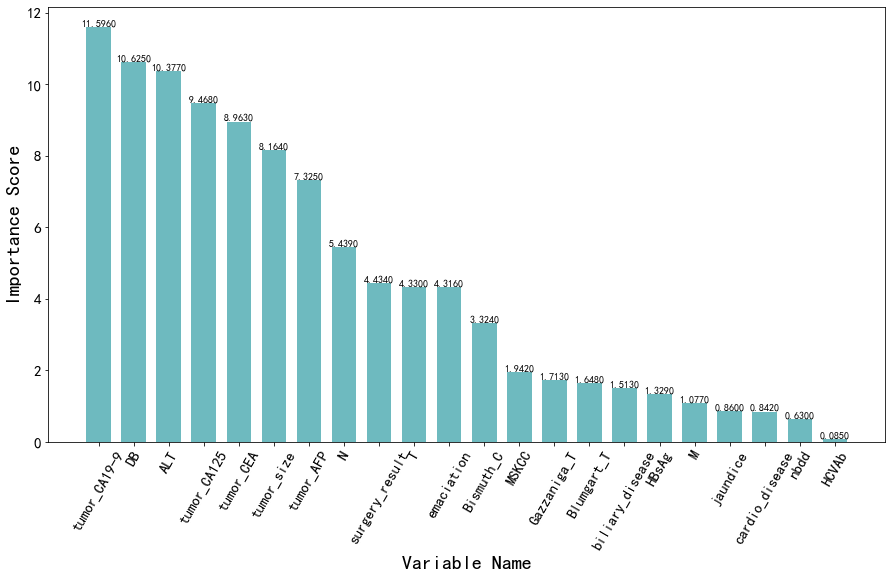

In [358]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.42941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)
plt.xticks(rotation=60)

plt.ylabel('Importance Score',fontsize=20)
plt.xlabel('Variable Name',fontsize=20)
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [ ]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [ ]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

### AUC曲线

In [ ]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

In [ ]:
plt.figure(figsize=(10,10))

# plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
# plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
# plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

#### summary_plot

In [ ]:
pd.value_counts(tran_y_sm)

In [ ]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import catboost,xgboost
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
cat_model.fit(tran_x_sm, tran_y_sm)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(tran_x_sm)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)

In [ ]:
tran_x_sm=tran_x_sm.rename(columns={'日剂量':'上一次日剂量',
                                   'gender':'性别',
                                   'age':'年龄',
                                   'test_result':'上一次TDM值'})

In [ ]:
?shap.summary_plot

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x_sm,plot_size=(12,8),
                 class_names=['1mg','1.5mg','4mg','3mg','2.5mg','2mg'])

In [ ]:
tran_x_sm.columns

In [ ]:
type(shap_values)

In [ ]:
df_shap_values

In [ ]:
df_shap = pd.DataFrame(data={'features':shap_col,
                            'shap_pos':shap_pos_list,
                            'shap_neg':shap_neg_list})

In [ ]:
df_shap

In [ ]:
df_shap.to_excel(project_path+'/data/result/df_shap.xlsx')

In [ ]:
shap_list=[]
for i in range(df_shap_values.shape[1]-1):
    shap_value=df_shap_values.iloc[:,i].sum()
    shap_list.append(shap_value)
df_shap = pd.DataFrame(data={'features':tran_x_sm.columns,
                            'shap_value':shap_list})

In [ ]:
df_shap_values.iloc[:,i]

In [ ]:
shap_list

In [ ]:
df_shap

In [ ]:
writer = pd.ExcelWriter(project_path + '/data/result/df_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()

#### multioutput_decision_plot

In [ ]:
?shap.multioutput_decision_plot

In [ ]:
col=df_model.columns.to_list()
col.remove('label')

In [ ]:
col

In [ ]:
shap.multioutput_decision_plot(shap_values,shap_values,row_index=3,
                              feature_names=col)

In [ ]:
shap_values

### 混淆矩阵图

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import catboost
# CatBoost模型
cat_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.001,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)
# 计算混淆矩阵
cat_confusion=confusion_matrix(test_y,cat_predictions)

In [ ]:
cat_confusion

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cat_confusion, cmap=plt.cm.Blues) # 在特定的窗口上显示图像
# 设置图表标题
plt.title('XGBoost Confusion Matrix',size=20)    # 图像标题
plt.colorbar()
# 设置坐标轴标题
font_x = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,}
plt.xlabel('prediction label',font_x)
plt.ylabel('True label',font_x)
# 设置坐标轴刻度
plt.tick_params(labelsize=23)  # 设置刻度值大小
label_names=['1g','1.5g','2mg','2.5mg','3mg','4mg']
plt.xticks(range(len(label_names)),label_names)
plt.yticks(range(len(label_names)),label_names)
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        plt.text(second_index,first_index, cat_confusion[first_index][second_index],size=20)
plt.show()

In [ ]:
cat_confusion

In [ ]:
for first_index in range(len(cat_confusion)):    #第几行
    print(cat_confusion[first_index])
    break

In [ ]:
for second_index in range(len(cat_confusion[first_index])):    #第几列
    print(cat_confusion[first_index][second_index])

In [ ]:
# 显示数据
for first_index in range(len(cat_confusion)):    #第几行
    for second_index in range(len(cat_confusion[first_index])):    #第几列
        print(first_index, second_index)
        print(cat_confusion[first_index][second_index])
        plt.text(first_index, second_index, cat_confusion[first_index][second_index],size=20)
plt.show()

### tabnet mask graph

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=15,
        num_workers=0,
        drop_last=False)

In [ ]:
explain_matrix,masks=TabNet_model.explain(tran_x_sm.to_numpy())

In [ ]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(40,40))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.yticks(np.arange(0, len(explain_matrix), 1.0))
# plt.xticks(np.arange(0, len(explain_matrix[0]), 1.0))
# ax.set_xticklabels(tran_x_sm.columns, rotation=75)
# plt.ylabel('Sample Number')
# plt.xlabel('Variable')
# # plt.imshow(explain_matrix[:30])  # 显示30个

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].set_yticks(np.arange(0, len(explain_matrix), 1.0))  # 设置左边间距
    axs[i].set_xticks(np.arange(0, len(explain_matrix[0]), 2.0))
    axs[i].set_ylabel('Sample Number',size=20)
    axs[i].set_xlabel('Variable',size=20)
    # 设置坐标刻度值的大小
    axs[i].tick_params(labelsize=15)
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(tran_x_sm.columns[::2], rotation=90)

In [ ]:
tran_x_sm.columns